# Estimating the strength of the regional field

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import string

import boule
import numpy as np
import pandas as pd
import seaborn as sns
import verde
import verde as vd
import xarray as xr
from matplotlib import patheffects
from matplotlib import pyplot as plt
from polartoolkit import fetch, maps, profiles, regions
from polartoolkit import utils as polar_utils
import geopandas as gpd
import scipy as sp
import os
import RIS_gravity_inversion.plotting as RIS_plotting
from RIS_gravity_inversion import ice_shelf_stats
from invert4geom import utils as invert4geom_utils
from RIS_gravity_inversion import gravity_processing
from adjustText import adjust_text
import matplotlib as mpl

import logging

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

import logging
# logging.basicConfig()
logging.getLogger("RIS_gravity_inversion").setLevel(logging.INFO)

from invert4geom import inversion, plotting, regional, uncertainty, utils

## Ice shelf masks
Here we gather regional masks for some of the major Antarctic ice shelves. We will use bedmachine 

In [26]:
ice_shelves = ice_shelf_stats.get_ice_shelves()
ice_shelves

INFO:RIS_gravity_inversion:Number of unmerged ice shelves: 180
INFO:RIS_gravity_inversion:Combining 2 Ronne_Filchner sub-shelves
INFO:RIS_gravity_inversion:Combining 7 Abbot sub-shelves


INFO:RIS_gravity_inversion:Combining 5 Wordie sub-shelves
INFO:RIS_gravity_inversion:Combining 3 Getz sub-shelves
INFO:RIS_gravity_inversion:Combining 2 Ross sub-shelves
INFO:RIS_gravity_inversion:Combining 2 Walgreen sub-shelves
INFO:RIS_gravity_inversion:Combining 2 Rydberg sub-shelves
INFO:RIS_gravity_inversion:Combining 2 LarsenD sub-shelves
INFO:RIS_gravity_inversion:Number of removed sub-shelves: 25
INFO:RIS_gravity_inversion:Number of merged ice shelves: 164


NAME    Regions TYPE  \
0                 Ross       West   FL   
1       Ronne_Filchner       West   FL   
2                Amery       East   FL   
3              LarsenC  Peninsula   FL   
4        Riiser-Larsen       East   FL   
..                 ...        ...  ...   
159            Perkins       West   FL   
160         Rose_Point       West   FL   
161              Arneb       East   FL   
162            Falkner       East   FL   
163  Hamilton_Piedmont    Islands   FL   

                                              geometry   area_km  
0    POLYGON ((-240677.184 -678259.006, -240038.274...  480428.0  
1    POLYGON ((-1006734.891 880592.980, -1006335.92...  427042.0  
2    POLYGON ((2134701.422 618463.117, 2131452.011 ...   60797.0  
3    POLYGON ((-2235724.269 1271352.188, -2235828.5...   47444.0  
4    POLYGON ((-592166.317 1592824.258, -593783.160...   42913.0  
..                                                 ...       ...  
159  POLYGON ((-1129608.753 -1201300.734, -1130034....       7.0  
160  POLYGON ((-1147927.179 -1208825.172, -1147730....       7.0  
161  POLYGON ((333867.825 -1897953.452, 333673.461 ...       6.0  
162  POLYGON ((425350.532 -1726631.609, 423726.753 ...       6.0  
163  POLYGON ((-1589132.027 -582392.525, -1589188.1...       6.0  

[164 rows x 5 columns]

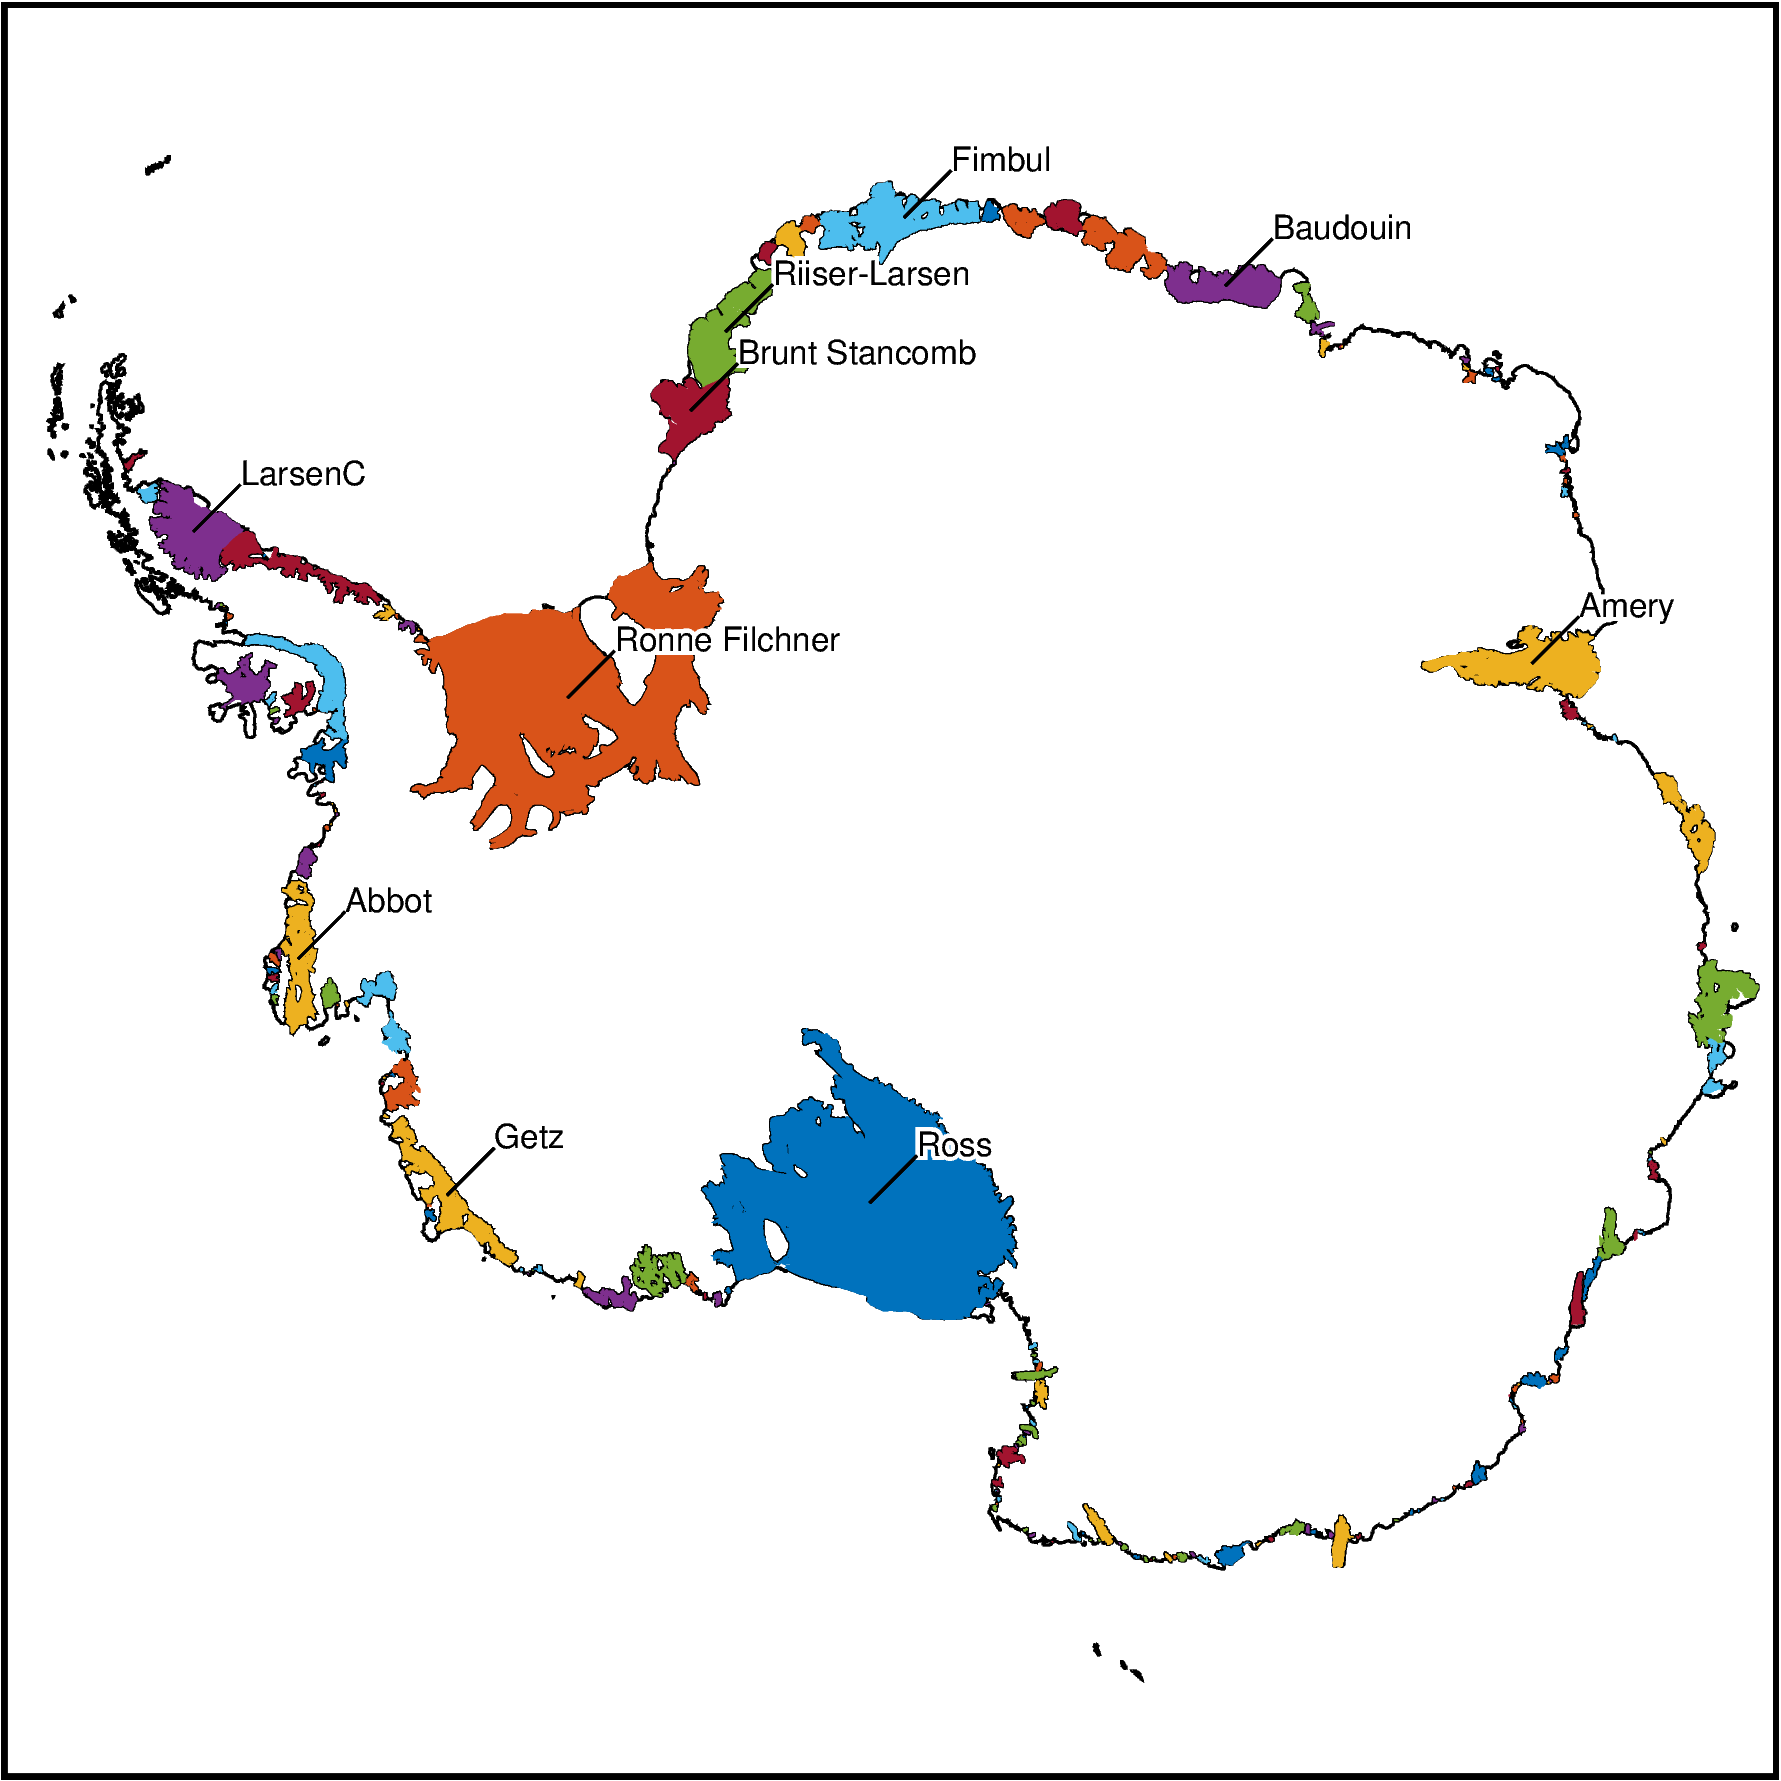

In [3]:
# choose how many ice shelves to plot
df = ice_shelves#.iloc[0:80]

# plot basemap with coastline and grounding lines
fig = maps.basemap(
    region=regions.antarctica,
    coast=True,
)

# plot ice shelves
fig.plot(
    df,
    close=True,
    fill="auto",
)

# plot names
ice_shelf_stats.plot_ice_shelf_names(fig, df.iloc[0:10])

fig.show()

In [4]:
ice_shelves.NAME.unique()

array(['Ross', 'Ronne_Filchner', 'Amery', 'LarsenC', 'Riiser-Larsen',
       'Fimbul', 'Brunt_Stancomb', 'Getz', 'Baudouin', 'Abbot',
       'Shackleton', 'George_VI', 'LarsenD', 'Borchgrevink', 'West',
       'Wilkins', 'Sulzberger', 'Jelbart', 'Lazarev', 'Stange', 'Nivl',
       'Ekstrom', 'Nickerson', 'Totten', 'Pine_Island',
       'Moscow_University', 'Dotson', 'Mertz', 'Prince_Harald',
       'Thwaites', 'Bach', 'Cook', 'Crosson', 'Rennick', 'Venable',
       'Cosgrove', 'Tracy_Tremenchus', 'Mariner', 'Holmes', 'Drygalski',
       'LarsenB', 'Quar', 'Vigrid', 'Atka', 'Nansen', 'Ninnis',
       'Conger_Glenzer', 'Publications', 'Dibble', 'LarsenE',
       'Vincennes_Bay', 'WilmaRobertDowner', 'Swinburne', 'Shirase',
       'LarsenF', 'Aviator', 'Lillie', 'LarsenA', 'Voyeykov',
       'Rayner_Thyer', 'Land', 'Withrow', 'Lauritzen', 'Mendelssohn',
       'Tucker', 'Edward_VIII', 'LarsenG', 'Hannan', 'Fitzgerald',
       'Mulebreen', 'Helen', 'Wordie', 'Slava', 'Williamson', 'Zubchat

In [5]:
logging.getLogger("RIS_gravity_inversion").setLevel(logging.DEBUG)

# Constraints and median distance

### create files for each ice shelves: csv for constraints and netcdf for min distances

In [21]:
# # for an individual ice shelf
# ice_shelf_stats.constraints_and_min_distances_single(
#     ice_shelves[ice_shelves.NAME == "Baudouin"].iloc[0],
#     spacing = 1e3,
#     grounded_as_points=True,
#     plot=True,
#     fname="../../data/Baudouin",
# )

In [22]:
# # for a range of ice shelves
# ice_shelf_stats.constraints_and_min_distances(
#     ice_shelves.iloc[40:42],
#     spacing = 1e3,
#     grounded_as_points=True,
#     plot=True,
#     file_path="../../data/",
# )

### Load the files, calculate stats and plot

In [23]:
# # for a range of ice shelves
# ice_shelves_subset = ice_shelf_stats.load_constraints_and_min_distances(
#     ice_shelves.iloc[12:14],
#     plot=True,
#     # save_plot=True,
#     file_path="../../data/",
# )
# ice_shelves_subset

# Gravity anomalies

### Calculate gravity anomalies and save to a csv
loads constraints from file so they must exist already (use the above functions)

In [24]:
# # for an individual ice shelf
# ice_shelf_stats.gravity_anomalies_single(
#     ice_shelves[ice_shelves.NAME == "Baudouin"].iloc[0],
#     buffer=10e3,
#     spacing = 10e3,
#     constraints_df=pd.read_csv("../../data/Baudouin_constraints.csv.gz"),
#     regional_grav_kwargs=dict(
#         method="constraints",
#         grid_method="pygmt",
#         tension_factor=0.25,
#     ),
#     progressbar=True,
#     plot=True,
#     fname="../../data/Baudouin",
# )


In [25]:
# # for a range of ice shelves
# ice_shelf_stats.gravity_anomalies(
#     ice_shelves.iloc[0:2],
#     buffer=10e3,
#     spacing = 5e3,
#     regional_grav_kwargs=dict(
#         method="constraints",
#         grid_method="pygmt",
#         tension_factor=0.25,
#     ),
#     progressbar=True,
#     plot=True,
#     # save_plot=True,
#     file_path="../../data/",
# )

### Load the files, calculate stats and plot

In [26]:
# ice_shelves.iloc[40:42]

In [27]:
# # for a range of ice shelves
# ice_shelves_subset = ice_shelf_stats.load_grav_anomalies(
#     ice_shelves,
#     # plot=True,
#     # save_plot=True,
#     file_path="../../data/",
# )
# ice_shelves_subset

# Load constraints, minimum distances, and gravity anomaly files

In [75]:
ice_shelves.iloc[80]

NAME                                                    Frost
Regions                                                  East
TYPE                                                       FL
geometry    MULTIPOLYGON (((1959268.2166107665 -1599529.97...
area_km                                                 229.0
Name: 80, dtype: object

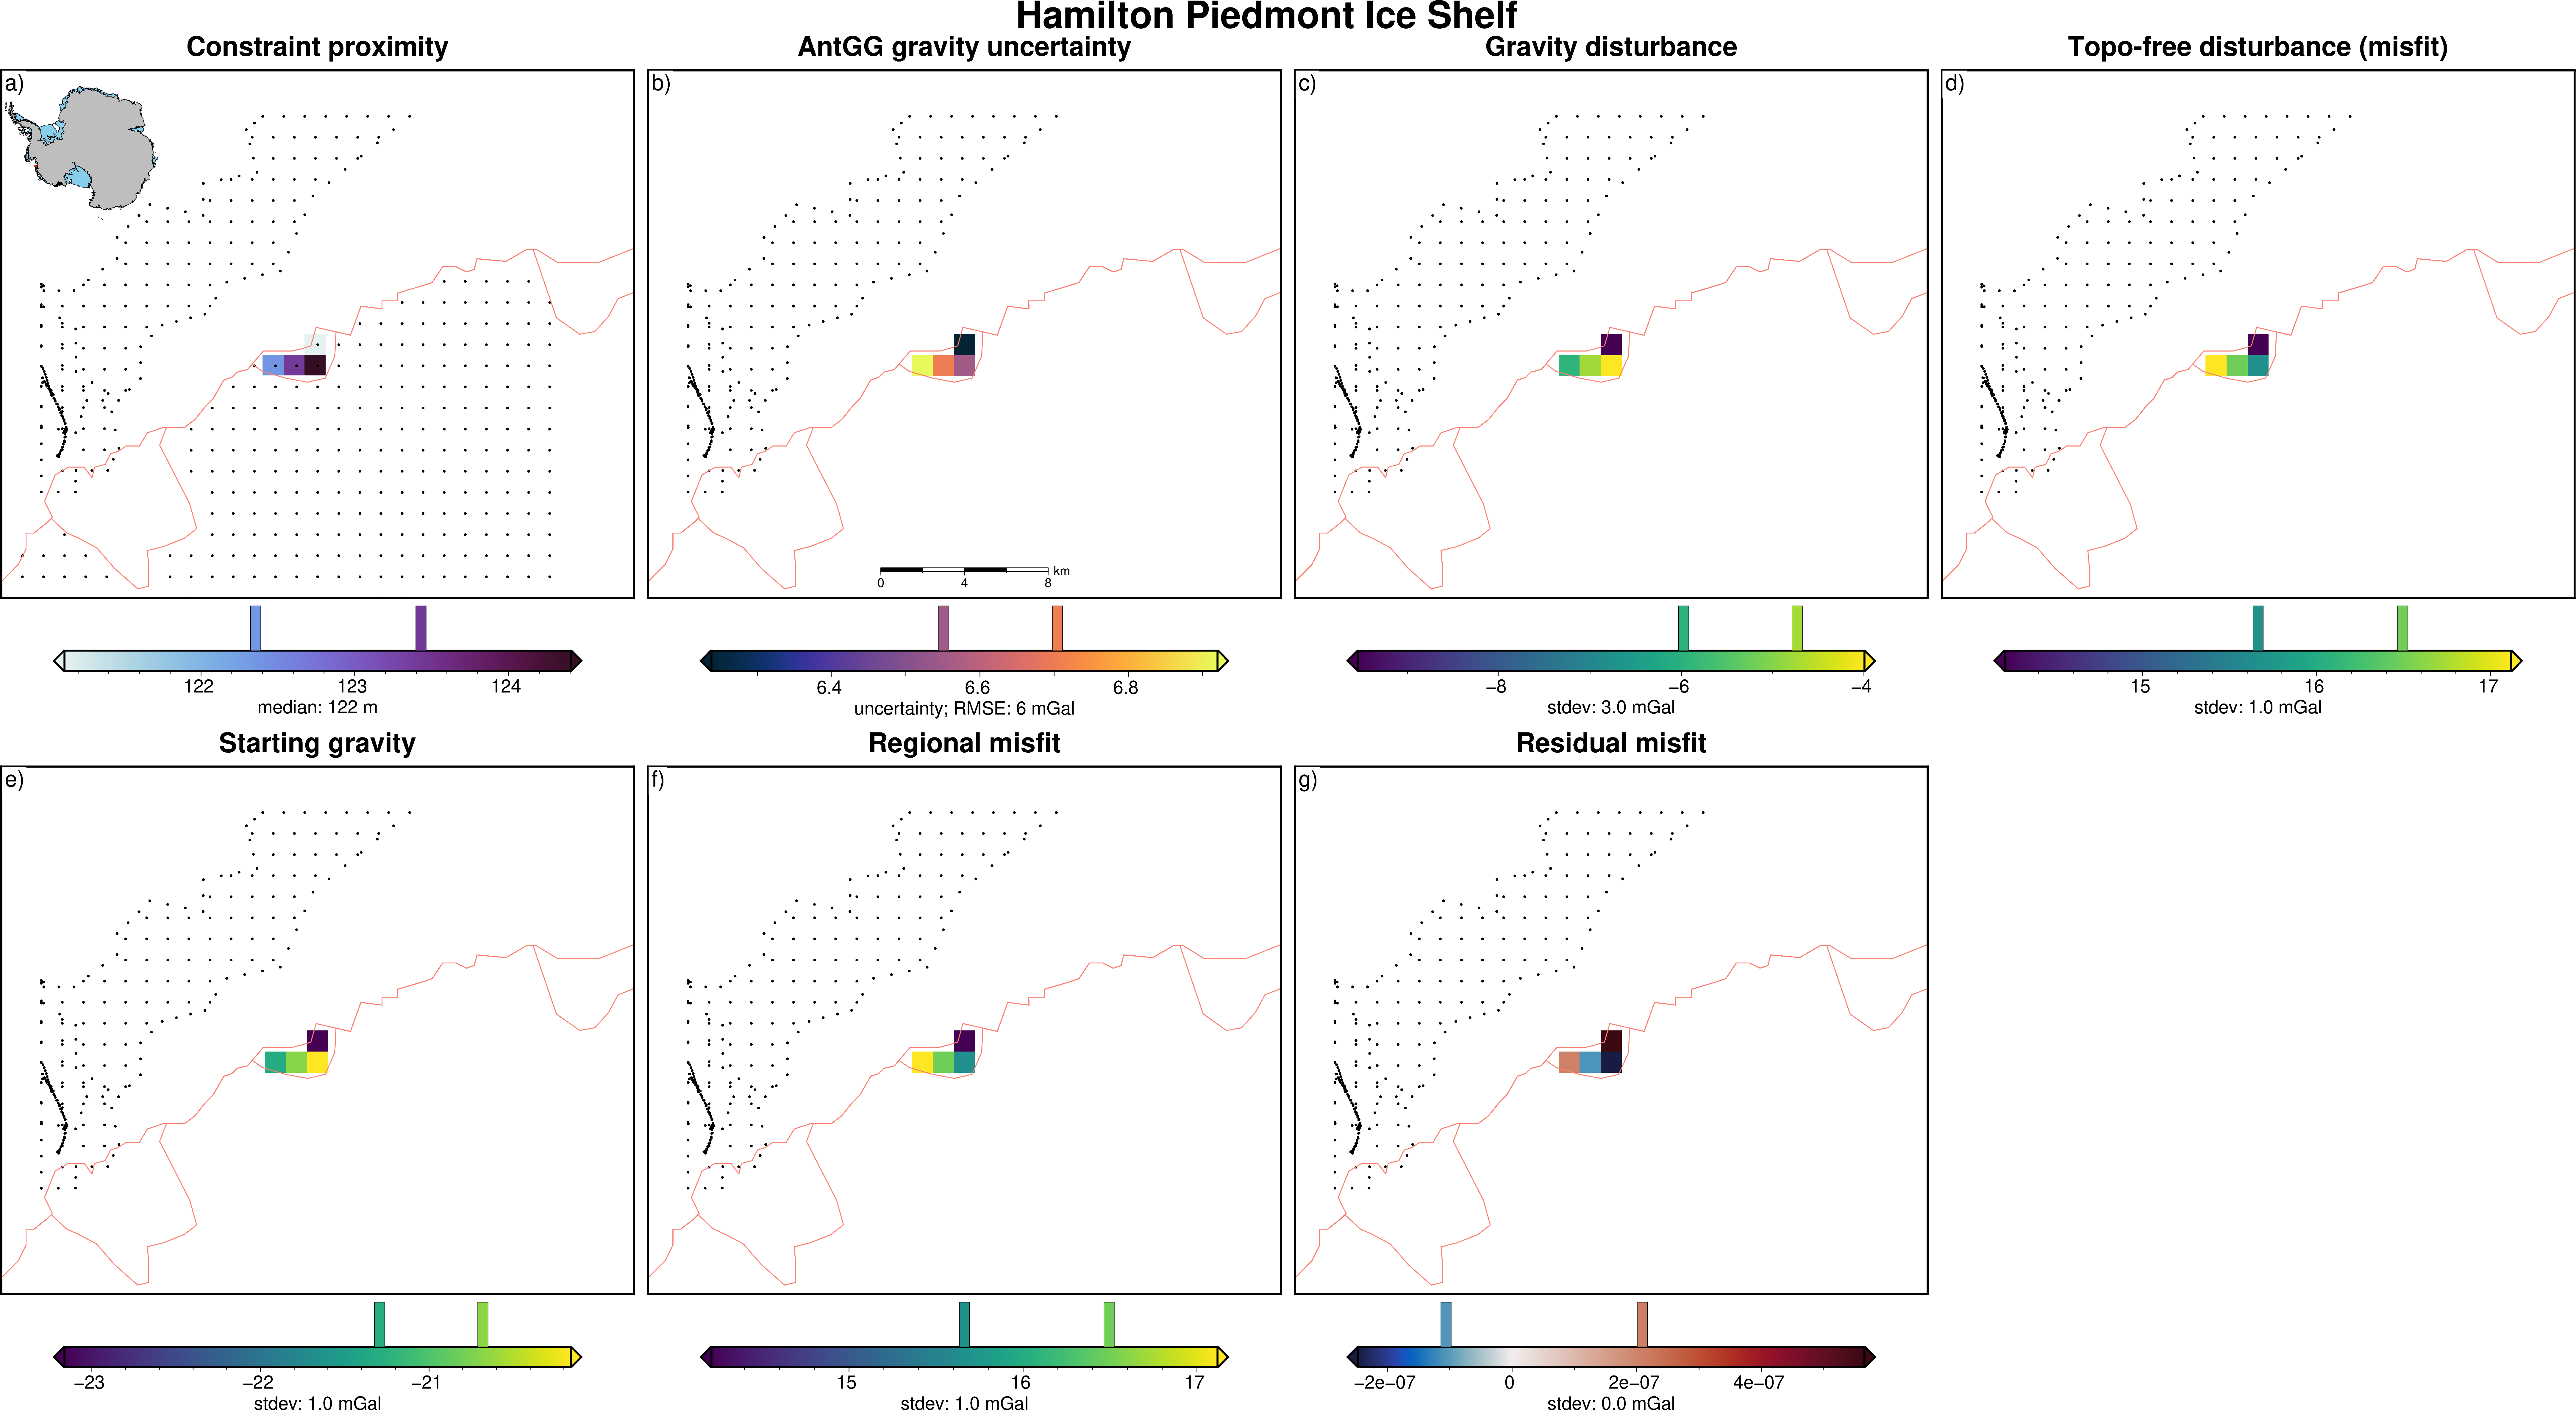

NAME  Regions TYPE  \
163  Hamilton_Piedmont  Islands   FL   

                                              geometry area_km  \
163  POLYGON ((-1589132.027 -582392.525, -1589188.1...     6.0   

     median_constraint_distance  gravity_disturbance_rms  \
163                  122.889479                 6.496965   

     gravity_disturbance_stdev  partial_topo_free_disturbance_rms  \
163                   2.577001                           5.892665   

     partial_topo_free_disturbance_stdev  ...    reg_rms  reg_stdev  \
163                             2.448606  ...  15.894965   1.311008   

          res_rms     res_stdev  error_rms  error_stdev  \
163  3.410493e-07  3.736904e-07   6.607196     0.300524   

     residual_constraint_proximity_ratio_rms  \
163                                 0.000042   

     residual_constraint_proximity_ratio_stdev  \
163                                   0.000046   

     regional_constraint_proximity_ratio_rms  \
163                              1954.961613   

     regional_constraint_proximity_ratio_stdev  
163                                 171.648099  

[1 rows x 24 columns]

In [82]:
# for an individual ice shelf
shelf = ice_shelf_stats.load_ice_shelf_info_single(
    # ice_shelves.iloc[80],
    ice_shelves[ice_shelves.NAME=="Hamilton_Piedmont"].iloc[0],
    plot=True,
    save_plot=False,
    file_path="../../data/",
)
shelf

In [29]:
# ice_shelves[ice_shelves.NAME == "Bach"]

In [29]:
# for a range of ice shelves
ice_shelf_stats_gdf = ice_shelf_stats.load_ice_shelf_info(
    ice_shelves,#.iloc[31:],
    plot=True,
    save_plot=True,
    file_path="../../data/",
)
ice_shelf_stats_gdf

Ice Shelves:   0%|          | 0/164 [00:00<?, ?it/s]

grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline
grdinfo [WARNING]: Guessing of r

NAME    Regions TYPE  \
0                 Ross       West   FL   
1       Ronne_Filchner       West   FL   
2                Amery       East   FL   
3              LarsenC  Peninsula   FL   
4        Riiser-Larsen       East   FL   
..                 ...        ...  ...   
159            Perkins       West   FL   
160         Rose_Point       West   FL   
161              Arneb       East   FL   
162            Falkner       East   FL   
163  Hamilton_Piedmont    Islands   FL   

                                              geometry   area_km  \
0    POLYGON ((-240677.184 -678259.006, -240038.274...  480428.0   
1    POLYGON ((-1006734.891 880592.980, -1006335.92...  427042.0   
2    POLYGON ((2134701.422 618463.117, 2131452.011 ...   60797.0   
3    POLYGON ((-2235724.269 1271352.188, -2235828.5...   47444.0   
4    POLYGON ((-592166.317 1592824.258, -593783.160...   42913.0   
..                                                 ...       ...   
159  POLYGON ((-1129608.753 -1201300.734, -1130034....       7.0   
160  POLYGON ((-1147927.179 -1208825.172, -1147730....       7.0   
161  POLYGON ((333867.825 -1897953.452, 333673.461 ...       6.0   
162  POLYGON ((425350.532 -1726631.609, 423726.753 ...       6.0   
163  POLYGON ((-1589132.027 -582392.525, -1589188.1...       6.0   

     median_constraint_distance  gravity_disturbance_rms  \
0                  16438.369381                44.934094   
1                   7164.802566                41.514238   
2                  15183.930847                54.607713   
3                   8870.497478                14.847744   
4                  16583.214838                53.516817   
..                          ...                      ...   
159                  718.792028                33.593137   
160                  832.526805                29.468264   
161                  640.304434                81.777387   
162                  562.234141                35.906908   
163                  122.889479                 6.496965   

     gravity_disturbance_stdev  partial_topo_free_disturbance_rms  \
0                    14.663219                          43.662103   
1                    18.769872                          41.429561   
2                    44.217952                          55.333792   
3                    13.588458                          14.444266   
4                    37.949582                          52.971480   
..                         ...                                ...   
159                   3.571592                          33.666794   
160                   0.981304                          28.411324   
161                  11.153281                          79.323918   
162                   3.341045                          36.851665   
163                   2.577001                           5.892665   

     partial_topo_free_disturbance_stdev  ...    reg_rms  reg_stdev  \
0                              14.661921  ...  17.075245  16.697962   
1                              18.760552  ...  33.720993  20.579190   
2                              44.152812  ...  38.045945  21.303547   
3                              13.464743  ...  38.109721  12.964762   
4                              37.978854  ...  76.811886  37.814496   
..                                   ...  ...        ...        ...   
159                             2.657778  ...  25.029707   0.975564   
160                             0.779644  ...  19.805753   0.589294   
161                            11.615274  ...  72.517861  10.709236   
162                             2.682288  ...  37.795759   4.544636   
163                             2.448606  ...  15.894965   1.311008   

          res_rms     res_stdev  error_rms  error_stdev  \
0    5.376152e+00  5.361364e+00  12.748633     3.154937   
1    3.460521e+00  3.460078e+00   7.952294     1.760702   
2    1.457342e+01  1.258047e+01   8.435324     0.503457   
3    5.318446e+00  5.316355e+00   5.718122     1.274370  

## Clean up NaNs and outliers

In [30]:
# drop rows with any NaNs
to_drop = ice_shelf_stats_gdf[ice_shelf_stats_gdf.isna().any(axis=1)]
print(to_drop.NAME)

ice_shelf_stats_gdf = ice_shelf_stats_gdf.drop(to_drop.index).reset_index(drop=True)

ice_shelf_stats_gdf.describe()

Series([], Name: NAME, dtype: object)


median_constraint_distance  gravity_disturbance_rms  \
count                  164.000000               164.000000   
mean                  4038.622491                53.280008   
std                   3567.284796                33.934781   
min                    122.889479                 5.002654   
25%                   1721.460898                26.656216   
50%                   2735.357724                47.456515   
75%                   5216.414618                76.964010   
max                  20027.080067               201.145771   

       gravity_disturbance_stdev  partial_topo_free_disturbance_rms  \
count                 164.000000                         164.000000   
mean                   13.304118                          52.785677   
std                    12.379536                          33.646579   
min                     0.708608                           4.131890   
25%                     4.599125                          25.846058   
50%                    10.368297                          46.661398   
75%                    16.035651                          75.844572   
max                    71.319719                         199.406055   

       partial_topo_free_disturbance_stdev  topo_free_disturbance_rms  \
count                           164.000000                 164.000000   
mean                             13.138178                  42.257338   
std                              12.388704                  28.262982   
min                               0.779644                   4.177466   
25%                               4.444899                  20.767969   
50%                              10.089087                  35.752407   
75%                              16.250785                  58.269454   
max                              71.336115                 169.581628   

       topo_free_disturbance_stdev  starting_gravity_rms  \
count                   164.000000            164.000000   
mean                     11.911604             22.492880   
std                      11.459312             13.389944   
min                       1.220331              1.023399   
25%                       4.500077             12.767558   
50%                       8.515282             20.966016   
75%                      14.540932             28.181933   
max                      65.509566             67.080951   

       starting_gravity_stdev     reg_rms   reg_stdev       res_rms  \
count              164.000000  164.000000  164.000000  1.640000e+02   
mean                 6.470317   40.475773   10.001905  6.264412e+00   
std                  5.364055   28.209958   10.538670  5.022432e+00   
min                  0.661844    3.180607    0.266578  3.410493e-07   
25%                  2.905366   19.611147    3.328488  2.592959e+00   
50%                  4.783281   33.851949    6.616715  4.671097e+00   
75%                  8.049151   55.582568   11.424118  9.107986e+00   
max                 24.911896  159.329113   64.945010  2.353820e+01   

          res_stdev   error_rms  error_stdev  \
count  1.640000e+02  164.000000   164.000000   
mean   5.113209e+00    8.813137     1.022045   
std    3.975749e+00    3.241083     0.870812   
min    3.736904e-07    3.760287     0.043142   
25%    2.159672e+00    6.427932     0.205933   
50%    4.066616e+00    8.336575     0.863239   
75%    7.407397e+00   10.258664     1.536643   
max    1.738378e+01   15.205841     4.032590   

       residual_constraint_proximity_ratio_rms  \
count                               164.000000   
mean                              63348.737130   
std                               98226.830381   
min                                   0.000042   
25%                                6993.130203   
50%                               18430.022151   
75%                               78795.461184   
max                              564022.342094   

       residual_constraint_proximity_ratio_stdev  \
count                            

In [31]:
stats_to_check = [
    'gravity_disturbance_stdev',
    'partial_topo_free_disturbance_stdev',
    'topo_free_disturbance_stdev',
    'starting_gravity_stdev',
    'reg_stdev',
    'res_stdev',
    # 'error_stdev',
    "median_constraint_distance",
]

stats = ice_shelf_stats_gdf[stats_to_check].apply(sp.stats.zscore)

outliers = stats[(stats > 4).any(axis=1)]
cols = outliers.columns.tolist()
outliers = outliers.merge(ice_shelf_stats_gdf[["NAME"]], left_index=True, right_index=True, how="left")
outliers = outliers[["NAME"]+cols]
print(outliers.NAME.unique())
outliers

['Shackleton' 'Jelbart' 'Ekstrom' 'Drygalski']


NAME  gravity_disturbance_stdev  \
10  Shackleton                   1.144714   
17     Jelbart                   4.142314   
21     Ekstrom                   4.700765   
39   Drygalski                   2.813335   

    partial_topo_free_disturbance_stdev  topo_free_disturbance_stdev  \
10                             1.154733                     1.130848   
17                             4.159876                     4.217639   
21                             4.712049                     4.691566   
39                             2.783443                     4.224894   

    starting_gravity_stdev  reg_stdev  res_stdev  median_constraint_distance  
10                0.252677   0.706696   2.668263                    4.495696  
17                0.059554   3.983854   2.404363                    2.000660  
21                0.089531   5.229444  -0.026691                   -0.411478  
39                2.081002   4.451322   0.652859                    0.072029

In [41]:
# outlier_stats = ice_shelf_stats.load_ice_shelf_info(
#     ice_shelves[ice_shelves.NAME.isin(outliers.NAME.unique())],
#     plot=True,
#     # save_plot=True,
#     file_path="../../data/",
# )
# outlier_stats

In [ ]:
# decide to drop these shelves
# ice_shelf_stats_gdf = ice_shelf_stats_gdf.drop(outlier_stats.index).reset_index(drop=True)


In [32]:
ice_shelf_stats_gdf = ice_shelf_stats_gdf.sort_values("area_km", ascending=False)

In [33]:
ice_shelf_stats_gdf.NAME.unique()

array(['Ross', 'Ronne_Filchner', 'Amery', 'LarsenC', 'Riiser-Larsen',
       'Fimbul', 'Brunt_Stancomb', 'Getz', 'Baudouin', 'Abbot',
       'Shackleton', 'George_VI', 'LarsenD', 'Borchgrevink', 'West',
       'Wilkins', 'Sulzberger', 'Jelbart', 'Lazarev', 'Stange', 'Nivl',
       'Ekstrom', 'Nickerson', 'Totten', 'Pine_Island',
       'Moscow_University', 'Dotson', 'Mertz', 'Prince_Harald',
       'Thwaites', 'Bach', 'Cook', 'Crosson', 'Rennick', 'Venable',
       'Cosgrove', 'Tracy_Tremenchus', 'Mariner', 'Holmes', 'Drygalski',
       'LarsenB', 'Quar', 'Vigrid', 'Atka', 'Nansen', 'Ninnis',
       'Conger_Glenzer', 'Publications', 'Dibble', 'LarsenE',
       'Vincennes_Bay', 'WilmaRobertDowner', 'Swinburne', 'Shirase',
       'LarsenF', 'Aviator', 'Lillie', 'LarsenA', 'Voyeykov',
       'Rayner_Thyer', 'Land', 'Withrow', 'Lauritzen', 'Mendelssohn',
       'Tucker', 'Edward_VIII', 'LarsenG', 'Hannan', 'Fitzgerald',
       'Mulebreen', 'Helen', 'Wordie', 'Slava', 'Williamson', 'Zubchat

## Save and load to csv

In [34]:
ice_shelf_stats_gdf.columns

Index(['NAME', 'Regions', 'TYPE', 'geometry', 'area_km',
       'median_constraint_distance', 'gravity_disturbance_rms',
       'gravity_disturbance_stdev', 'partial_topo_free_disturbance_rms',
       'partial_topo_free_disturbance_stdev', 'topo_free_disturbance_rms',
       'topo_free_disturbance_stdev', 'starting_gravity_rms',
       'starting_gravity_stdev', 'reg_rms', 'reg_stdev', 'res_rms',
       'res_stdev', 'error_rms', 'error_stdev',
       'residual_constraint_proximity_ratio_rms',
       'residual_constraint_proximity_ratio_stdev',
       'regional_constraint_proximity_ratio_rms',
       'regional_constraint_proximity_ratio_stdev'],
      dtype='object')

In [35]:
ice_shelf_stats_gdf.to_csv("../../data/ice_shelf_gravity_stats.csv", index=False,)

In [36]:
ice_shelf_stats_gdf = pd.read_csv("../../data/ice_shelf_gravity_stats.csv", index_col=None)

# turn back into geodataframe
ice_shelf_stats_gdf = gpd.GeoDataFrame(
    ice_shelf_stats_gdf,
    geometry=gpd.GeoSeries.from_wkt(ice_shelf_stats_gdf['geometry'], crs="EPSG:3031"),
    crs="EPSG:3031",
)

# turn into km
ice_shelf_stats_gdf["median_constraint_distance"] = ice_shelf_stats_gdf["median_constraint_distance"] / 1e3

ice_shelf_stats_gdf.head()

NAME    Regions TYPE  \
0            Ross       West   FL   
1  Ronne_Filchner       West   FL   
2           Amery       East   FL   
3         LarsenC  Peninsula   FL   
4   Riiser-Larsen       East   FL   

                                            geometry   area_km  \
0  POLYGON ((-240677.184 -678259.006, -240038.274...  480428.0   
1  POLYGON ((-1006734.891 880592.980, -1006335.92...  427042.0   
2  POLYGON ((2134701.422 618463.117, 2131452.011 ...   60797.0   
3  POLYGON ((-2235724.269 1271352.188, -2235828.5...   47444.0   
4  POLYGON ((-592166.317 1592824.258, -593783.160...   42913.0   

   median_constraint_distance  gravity_disturbance_rms  \
0                   16.438369                44.934094   
1                    7.164803                41.514238   
2                   15.183931                54.607713   
3                    8.870497                14.847744   
4                   16.583215                53.516817   

   gravity_disturbance_stdev  partial_topo_free_disturbance_rms  \
0                  14.663219                          43.662103   
1                  18.769872                          41.429561   
2                  44.217952                          55.333792   
3                  13.588458                          14.444266   
4                  37.949582                          52.971480   

   partial_topo_free_disturbance_stdev  ...    reg_rms  reg_stdev    res_rms  \
0                            14.661921  ...  17.075245  16.697962   5.376152   
1                            18.760552  ...  33.720993  20.579190   3.460521   
2                            44.152812  ...  38.045945  21.303547  14.573418   
3                            13.464743  ...  38.109721  12.964762   5.318446   
4                            37.978854  ...  76.811886  37.814496  11.198799   

   res_stdev  error_rms  error_stdev  residual_constraint_proximity_ratio_rms  \
0   5.361364  12.748633     3.154937                            109411.809927   
1   3.460078   7.952294     1.760702                             51031.817496   
2  12.580467   8.435324     0.503457                            422143.617186   
3   5.316355   5.718122     1.274370                             65632.760934   
4  11.124435   8.282689     0.712841                            332133.545228   

   residual_constraint_proximity_ratio_stdev  \
0                              108973.906512   
1                               51000.501525   
2                              382878.269956   
3                               65551.197575   
4                              331949.811620   

   regional_constraint_proximity_ratio_rms  \
0                             2.645335e+05   
1                             3.285126e+05   
2                             1.003772e+06   
3                             4.938188e+05   
4                             1.767678e+06   

   regional_constraint_proximity_ratio_stdev  
0                               2.465043e+05  
1                               2.353756e+05  
2                               7.182766e+05  
3                               3.113619e+05  
4                               1.152930e+06  

[5 rows x 24 columns]

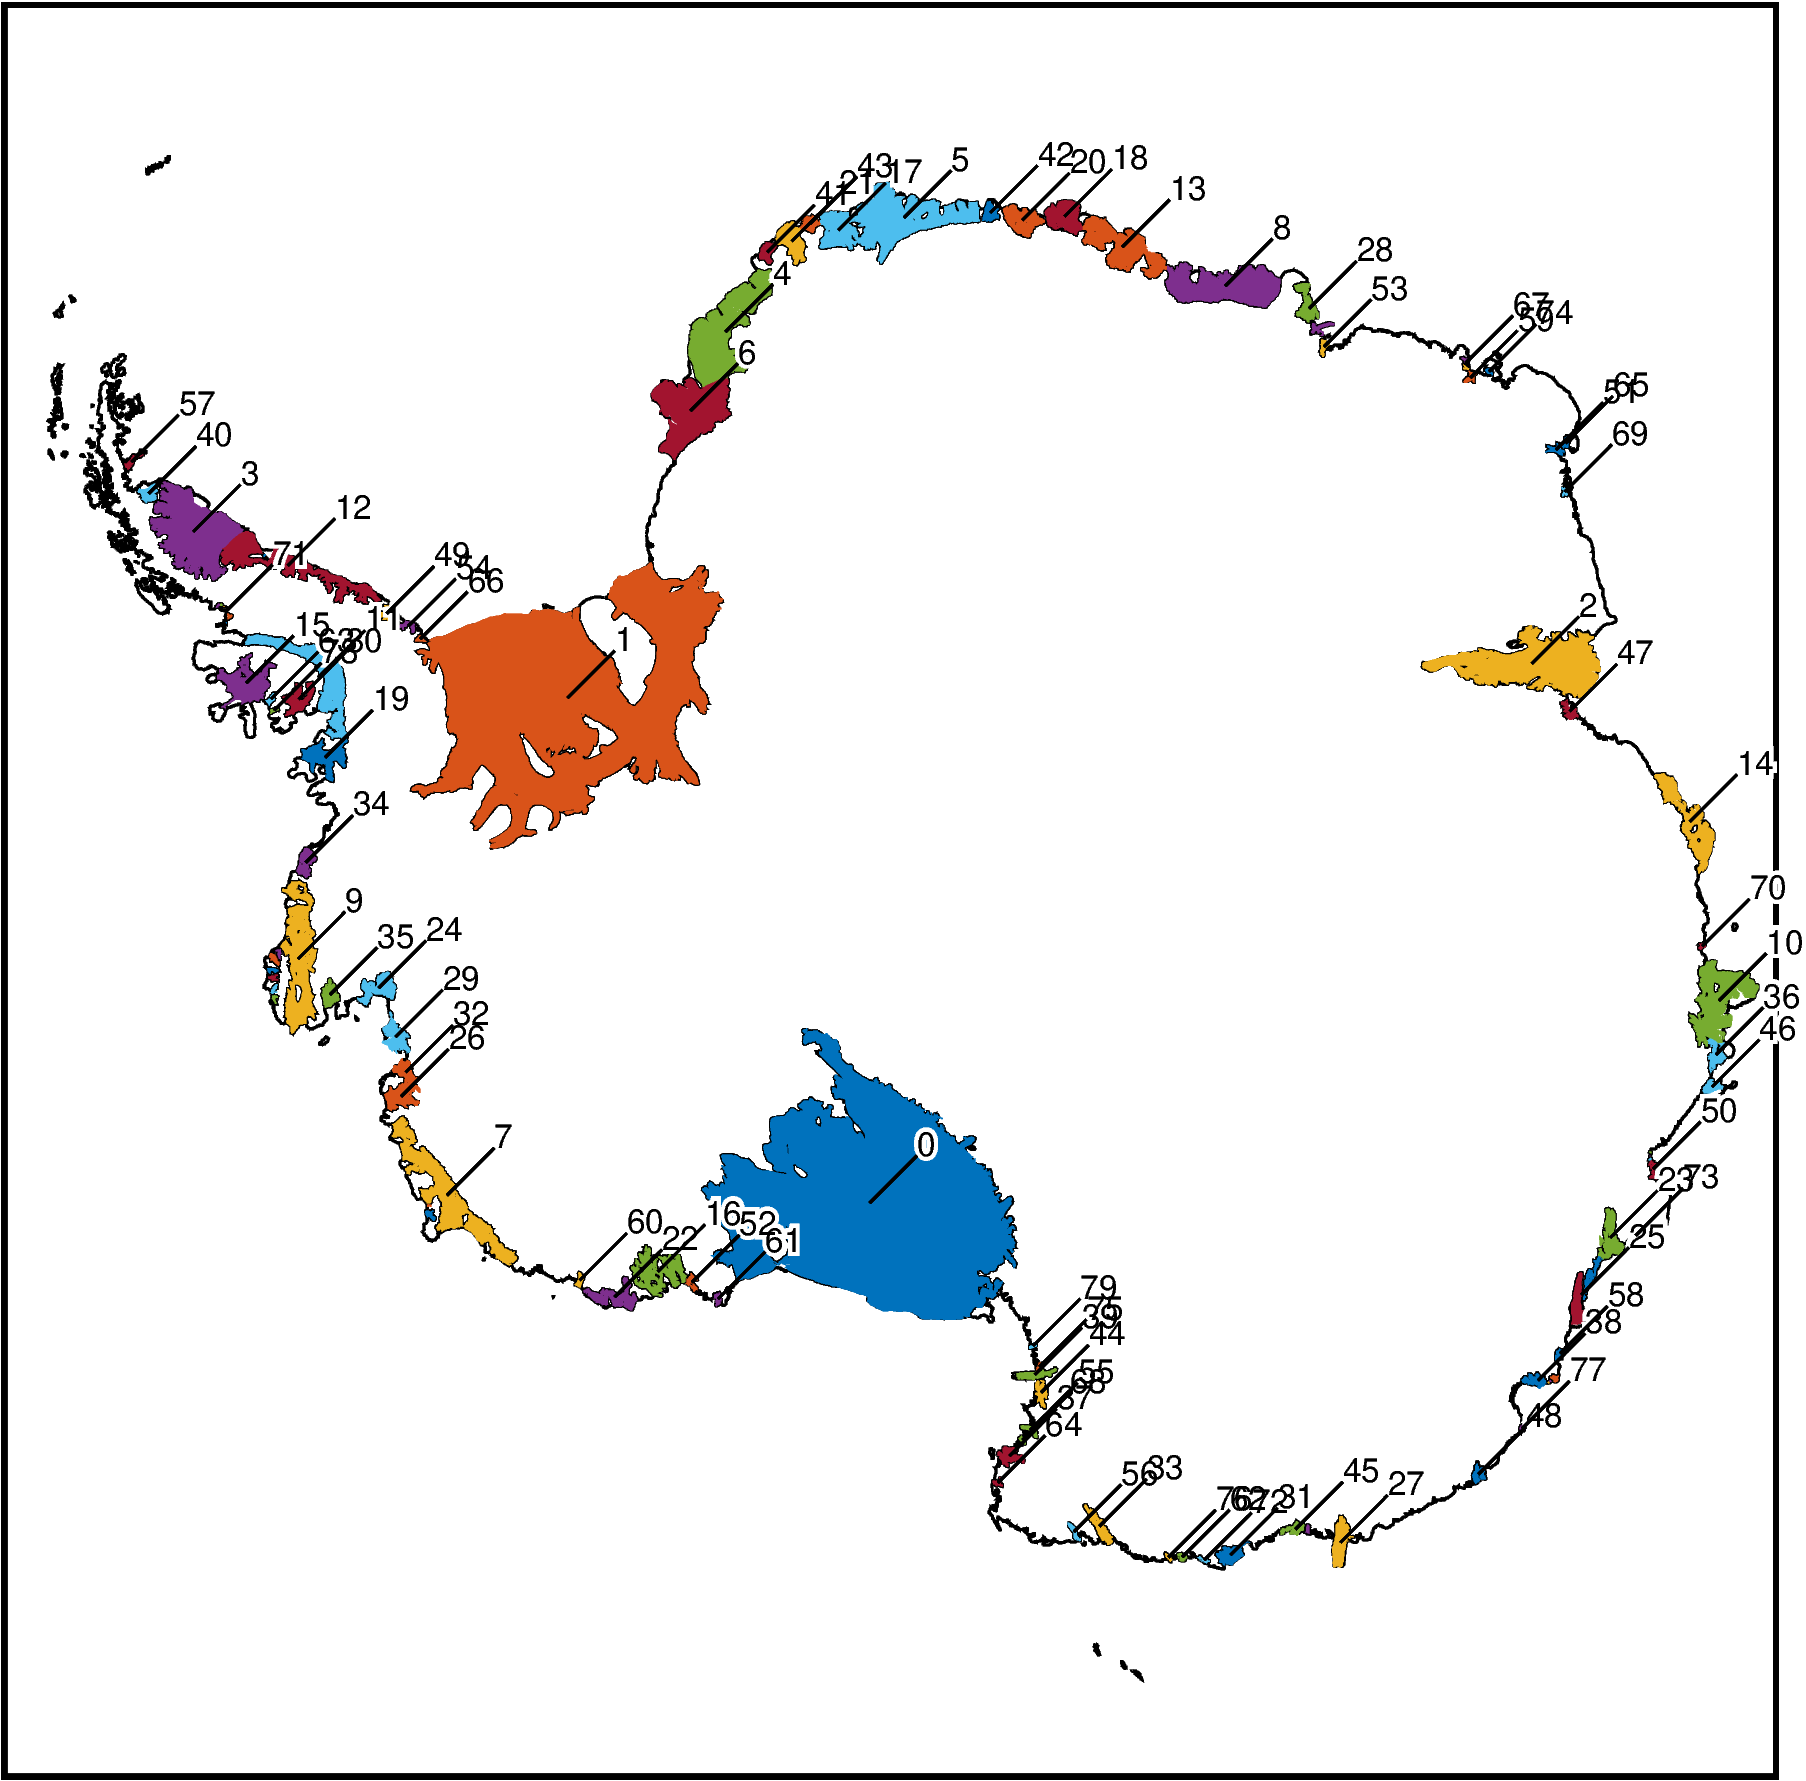

In [96]:
# choose how many ice shelves to plot
df = ice_shelf_stats_gdf.copy()
df = df.iloc[0:80]

# plot basemap with coastline and grounding lines
fig = maps.basemap(
    region=regions.antarctica,
    coast=True,
)

# plot ice shelves
fig.plot(
    df,
    close=True,
    fill="auto",
)

df["NAME"] = df.index.astype(str)

# plot names
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df,#.iloc[0:50],
    # offset=None,
)

fig.show()

In [85]:
ice_shelf_stats_gdf.iloc[0:80][
    ["area_km","median_constraint_distance", "topo_free_disturbance_stdev", "reg_stdev", "error_rms"]
].describe()

area_km  median_constraint_distance  topo_free_disturbance_stdev  \
count      80.000000                   80.000000                    80.000000   
mean    19018.700000                    6.289124                    18.671831   
std     71316.235054                    3.907367                    12.997869   
min       229.000000                    1.843496                     2.051017   
25%       646.000000                    3.558790                     9.912819   
50%      2216.000000                    5.237333                    15.132044   
75%      7474.000000                    7.211812                    21.904781   
max    480428.000000                   20.027080                    65.509566   

       reg_stdev  error_rms  
count  80.000000  80.000000  
mean   15.874151   7.904222  
std    12.336504   2.767319  
min     1.762493   3.760287  
25%     8.321889   6.025343  
50%    12.145499   7.364079  
75%    17.978109   8.484005  
max    64.945010  15.190674

In [ ]:
# plot with
# 1) histogram of topo-free disturbance stdev and estimated regional stdev
# 2) histogram of gravity error rms
# 3) histogram of median constraint distance


topo_free_disturbance_stdev:
 min: 2.0510172490878507
 max: 65.50956639346704
 mean: 18.671831211926385
 std: 12.997869135522985
reg_stdev:
 min: 1.7624928265983673
 max: 64.94501046042168
 mean: 15.87415095280873
 std: 12.336504416407928
error_rms:
 min: 3.760286514360474
 max: 15.190673765413065
 mean: 7.904222132805529
 std: 2.767318846462834
median_constraint_distance:
 min: 1.8434956081824911
 max: 20.0270800670126
 mean: 6.289123801807473
 std: 3.907367496883049


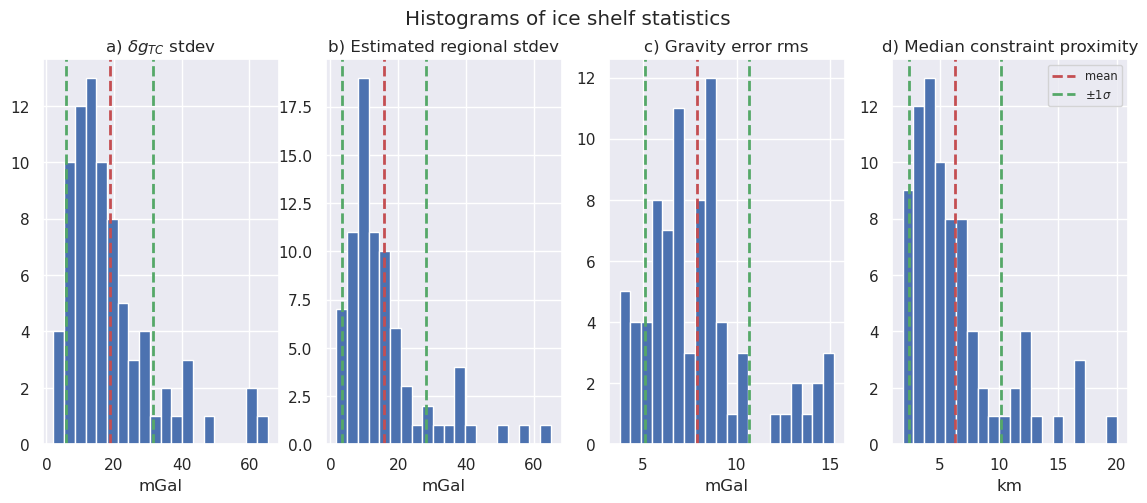

In [112]:
df = ice_shelf_stats_gdf[ice_shelf_stats_gdf.NAME.isin(ice_shelves.iloc[0:80].NAME)]
cols = [
    # 'partial_topo_free_disturbance_stdev',
    'topo_free_disturbance_stdev',
    'reg_stdev',
    'error_rms',
    'median_constraint_distance',
    # "area_km",
]

for col in cols:
    print(f"{col}:\n min: {df[col].min()}\n max: {df[col].max()}\n mean: {df[col].mean()}\n std: {df[col].std()}")

fig, axis = plt.subplots(1, len(cols), figsize=(14, 5))
fig.suptitle("Histograms of ice shelf statistics")

i = 0
# axis[i].hist(
#     df[cols[i]],
#     bins=20,
# )
# axis[i].set_title(r"$\delta g_{TC\_partial}$ stdev")
# axis[i].set_xlabel("mGal")
# mean = df[cols[i]].mean()
# std = df[cols[i]].std()
# axis[i].axvline(mean, color='r', linestyle='dashed', linewidth=2, label='mean')
# axis[i].axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='$\pm1\sigma$')
# axis[i].axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
# i+=1

axis[i].hist(
    df[cols[i]],
    bins=20,
)
axis[i].set_title(f"{string.ascii_lowercase[i]}) $\delta g_{{TC}}$ stdev")
axis[i].set_xlabel("mGal")
mean = df[cols[i]].mean()
std = df[cols[i]].std()
axis[i].axvline(mean, color='r', linestyle='dashed', linewidth=2, label='mean')
axis[i].axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='$\pm1\sigma$')
axis[i].axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
i+=1

axis[i].hist(
    df[cols[i]],
    bins=20,
)
axis[i].set_title(f"{string.ascii_lowercase[i]}) Estimated regional stdev")
axis[i].set_xlabel("mGal")
mean = df[cols[i]].mean()
std = df[cols[i]].std()
axis[i].axvline(mean, color='r', linestyle='dashed', linewidth=2, label='mean')
axis[i].axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='$\pm1\sigma$')
axis[i].axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
i+=1

axis[i].hist(
    df[cols[i]],
    bins=20,
)
axis[i].set_title(f"{string.ascii_lowercase[i]}) Gravity error rms")
axis[i].set_xlabel("mGal")
mean = df[cols[i]].mean()
std = df[cols[i]].std()
axis[i].axvline(mean, color='r', linestyle='dashed', linewidth=2, label='mean')
axis[i].axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='$\pm1\sigma$')
axis[i].axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
i+=1

axis[i].hist(
    df[cols[i]],
    bins=20,
)
axis[i].set_title(f"{string.ascii_lowercase[i]}) Median constraint proximity")
axis[i].set_xlabel("km")
mean = df[cols[i]].mean()
std = df[cols[i]].std()
axis[i].axvline(mean, color='r', linestyle='dashed', linewidth=2, label='mean')
axis[i].axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='$\pm1\sigma$')
axis[i].axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
i+=1

# axis[i].hist(
#     df[cols[i]],
#     bins=20,
# )
# axis[i].set_title("Ice Shelf Area")
# axis[i].set_xlabel("$km^2$")
# mean = df[cols[i]].mean()
# std = df[cols[i]].std()
# axis[i].axvline(mean, color='r', linestyle='dashed', linewidth=2, label='mean')
# axis[i].axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='$\pm1\sigma$')
# axis[i].axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
# i+=1


plt.legend(fontsize='x-small')

In [105]:
print(ice_shelf_stats.inverted_shelves)
print(len(ice_shelf_stats.inverted_shelves))

['Ross', 'Amery', 'Borchgrevink', 'Baudouin', 'George_VI', 'Thwaites', 'Cook', 'Ninnis', 'Ekstrom', 'Atka', 'Jelbart', 'Fimbul', 'Vigrid', 'Crosson', 'Dotson', 'Getz', 'Totten', 'Brunt_Stancomb', 'Pine_Island', 'Abbot', 'LarsenC', 'Nivl', 'Lazarev', 'Venable']
24


topo_free_disturbance_stdev:
 min: 10.726945477125048
 max: 65.50956639346704
 mean: 25.093962664016136
 std: 15.354753551582661
reg_stdev:
 min: 6.291325531874481
 max: 64.94501046042168
 mean: 21.37649687473991
 std: 15.413194332713507
error_rms:
 min: 3.760286514360474
 max: 12.748633008888326
 mean: 6.403395756595223
 std: 2.19874114778841
median_constraint_distance:
 min: 2.5752468925158083
 max: 16.63894395577333
 mean: 8.57991057858392
 std: 3.867439036294911


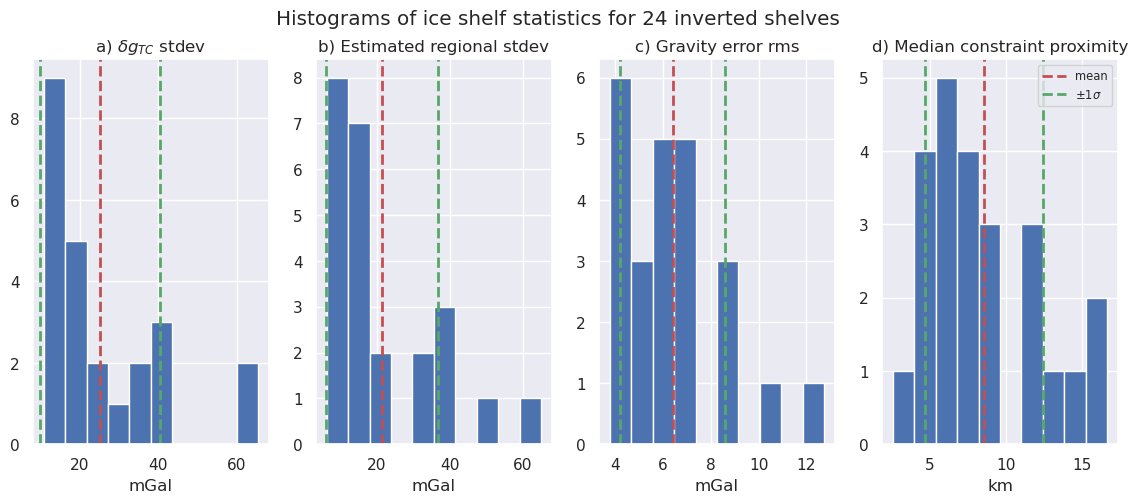

In [111]:
df = ice_shelf_stats_gdf[ice_shelf_stats_gdf.NAME.isin(ice_shelf_stats.inverted_shelves)]

cols = [
    'topo_free_disturbance_stdev',
    'reg_stdev',
    'error_rms',
    'median_constraint_distance',
]

for col in cols:
    print(f"{col}:\n min: {df[col].min()}\n max: {df[col].max()}\n mean: {df[col].mean()}\n std: {df[col].std()}")

fig, axis = plt.subplots(1, len(cols), figsize=(14, 5))
fig.suptitle("Histograms of ice shelf statistics for 24 inverted shelves")

i = 0

axis[i].hist(
    df[cols[i]],
    bins=10,
)
axis[i].set_title(f"{string.ascii_lowercase[i]}) $\delta g_{{TC}}$ stdev")
axis[i].set_xlabel("mGal")
mean = df[cols[i]].mean()
std = df[cols[i]].std()
axis[i].axvline(mean, color='r', linestyle='dashed', linewidth=2, label='mean')
axis[i].axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='$\pm1\sigma$')
axis[i].axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
i+=1

axis[i].hist(
    df[cols[i]],
    bins=10,
)
axis[i].set_title(f"{string.ascii_lowercase[i]}) Estimated regional stdev")
axis[i].set_xlabel("mGal")
mean = df[cols[i]].mean()
std = df[cols[i]].std()
axis[i].axvline(mean, color='r', linestyle='dashed', linewidth=2, label='mean')
axis[i].axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='$\pm1\sigma$')
axis[i].axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
i+=1

axis[i].hist(
    df[cols[i]],
    bins=10,
)
axis[i].set_title(f"{string.ascii_lowercase[i]}) Gravity error rms")
axis[i].set_xlabel("mGal")
mean = df[cols[i]].mean()
std = df[cols[i]].std()
axis[i].axvline(mean, color='r', linestyle='dashed', linewidth=2, label='mean')
axis[i].axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='$\pm1\sigma$')
axis[i].axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
i+=1

axis[i].hist(
    df[cols[i]],
    bins=10,
)
axis[i].set_title(f"{string.ascii_lowercase[i]}) Median constraint proximity")
axis[i].set_xlabel("km")
mean = df[cols[i]].mean()
std = df[cols[i]].std()
axis[i].axvline(mean, color='r', linestyle='dashed', linewidth=2, label='mean')
axis[i].axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='$\pm1\sigma$')
axis[i].axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
i+=1

plt.legend(fontsize='x-small')

Text(53.5276806640625, 0.5, 'Ice shelf area ($km^2$)')

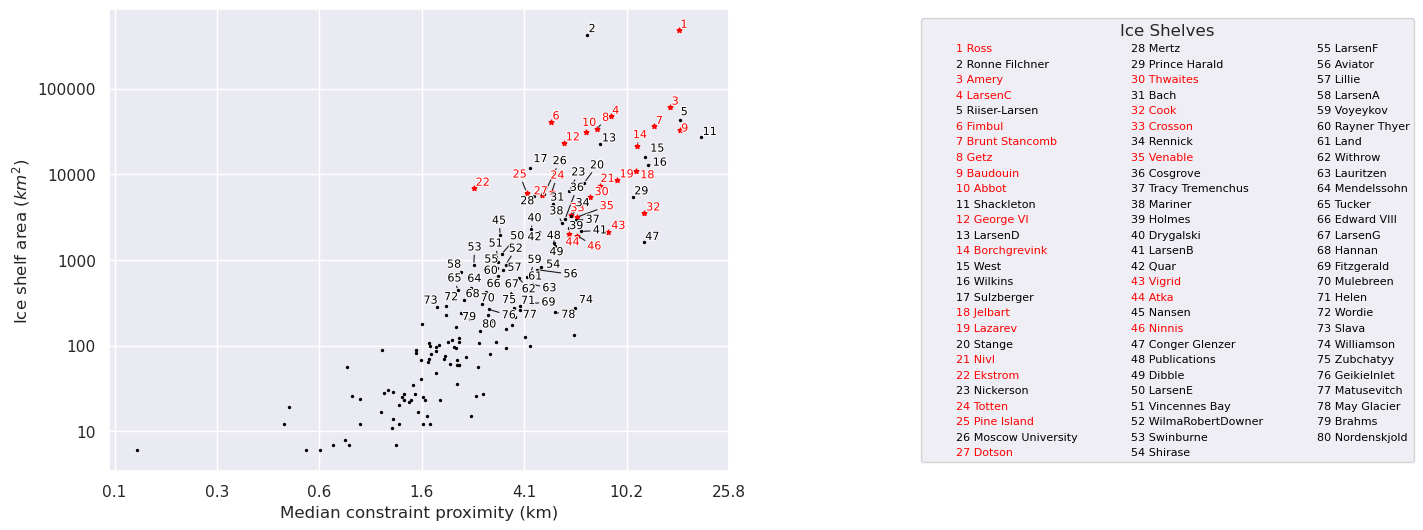

In [114]:
fig = ice_shelf_stats.ensemble_scatterplot(
    x="median_constraint_distance",
    y="area_km",
    ice_shelves=ice_shelf_stats_gdf,
    shelves_to_label=ice_shelf_stats_gdf[ice_shelf_stats_gdf.NAME.isin(ice_shelves.iloc[0:80].NAME)].NAME.unique(),
    # legend=False,
    legend_cols=3,
    # xlims=(0, 200e3),
    # ylims=(0, 600e3),
    logy=True,
    logx=True,
)
ax = fig.get_axes()[0]
# plt.gcf().text(0.1, 0.9, "a)", fontsize=16, va="bottom", ha="right")

# specify x ticks
ax.grid(True)
ax.set_xscale("log")
ax.minorticks_off()
vals = np.geomspace(0.1, ax.get_xlim()[1], 7)
ax.set_xticks(vals)

for axis in [ax.xaxis]:
    formatter = mpl.ticker.ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)
    axis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))

for axis in [ax.yaxis]:
    formatter = mpl.ticker.ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)
    axis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))


ax.set_xlabel("Median constraint proximity (km)")
ax.set_ylabel("Ice shelf area ($km^2$)")


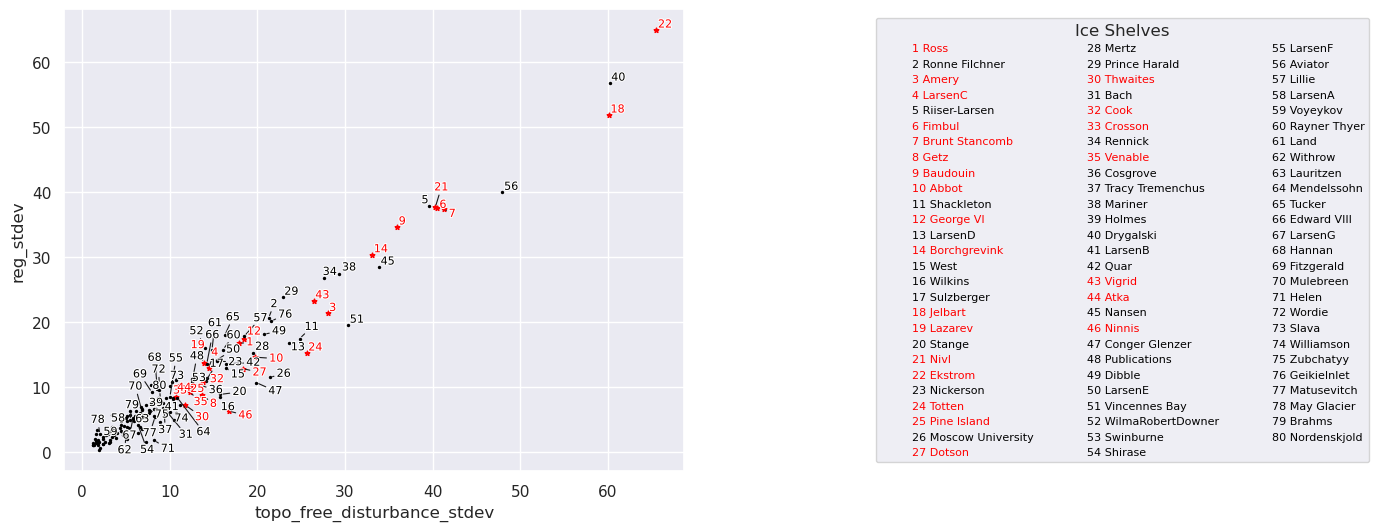

In [115]:
fig = ice_shelf_stats.ensemble_scatterplot(
    x="topo_free_disturbance_stdev",
    y='reg_stdev',
    ice_shelves=ice_shelf_stats_gdf,
    shelves_to_label=ice_shelf_stats_gdf[ice_shelf_stats_gdf.NAME.isin(ice_shelves.iloc[0:80].NAME)].NAME.unique(),
    # legend=False,
    # label_shelves=False,
    legend_cols=3,
    # xlims=(0, 200e3),
    # ylims=(0, 600e3),
)
ax = fig.get_axes()[0]
# plt.gcf().text(0.1, 0.9, "a)", fontsize=16, va="bottom", ha="right")


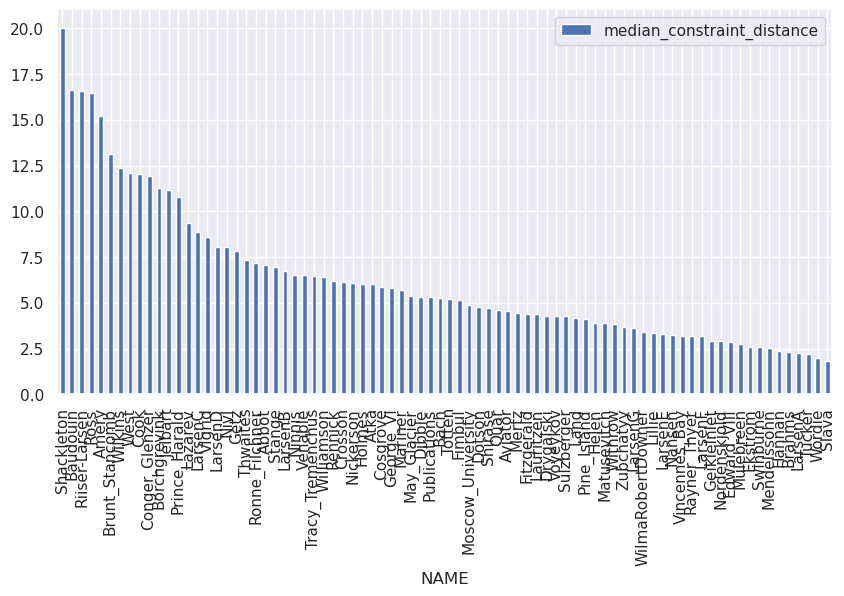

In [124]:
stat1 = "median_constraint_distance"
ax = ice_shelf_stats_gdf.iloc[0:80].sort_values([stat1], ascending=False).plot(
# ax = ice_shelf_stats_gdf.iloc[0:80].plot(
    x="NAME",
    y=[stat1],
    kind="bar",
    figsize=(10, 5),
    # width=1.2,
)
# ax.set_ylabel("")
# ax.set_yscale("log")
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

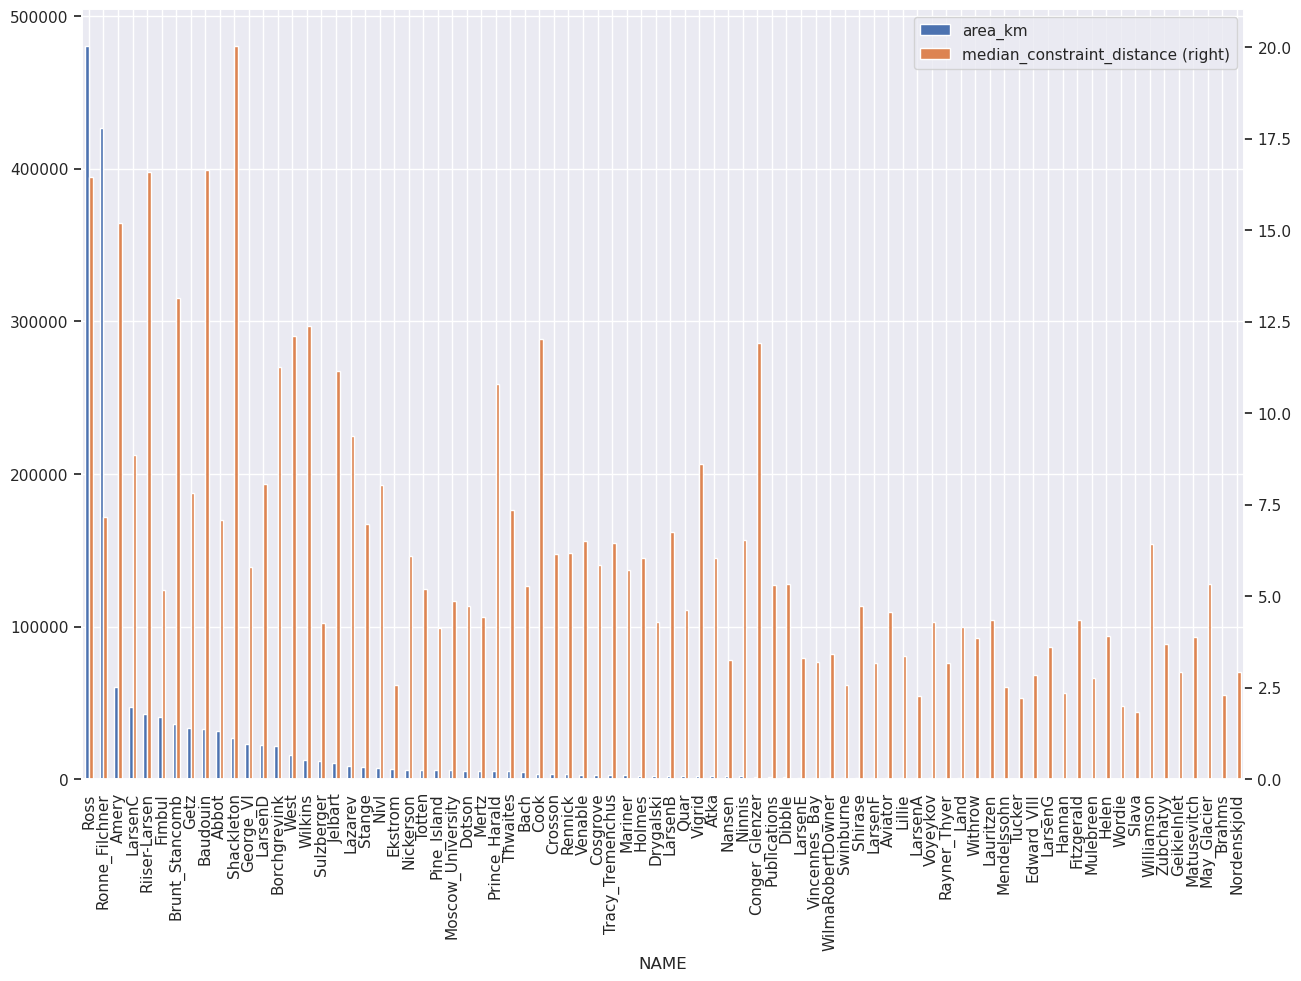

In [118]:
stat1 = "area_km"
stat2 = "median_constraint_distance"

ax = ice_shelf_stats_gdf.iloc[0:80].sort_values([stat1], ascending=False).plot(
    x="NAME",
    y=[stat1, stat2,],
    secondary_y=stat2,
    kind="bar",
    figsize=(15, 10),
    # width=1.2,
)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

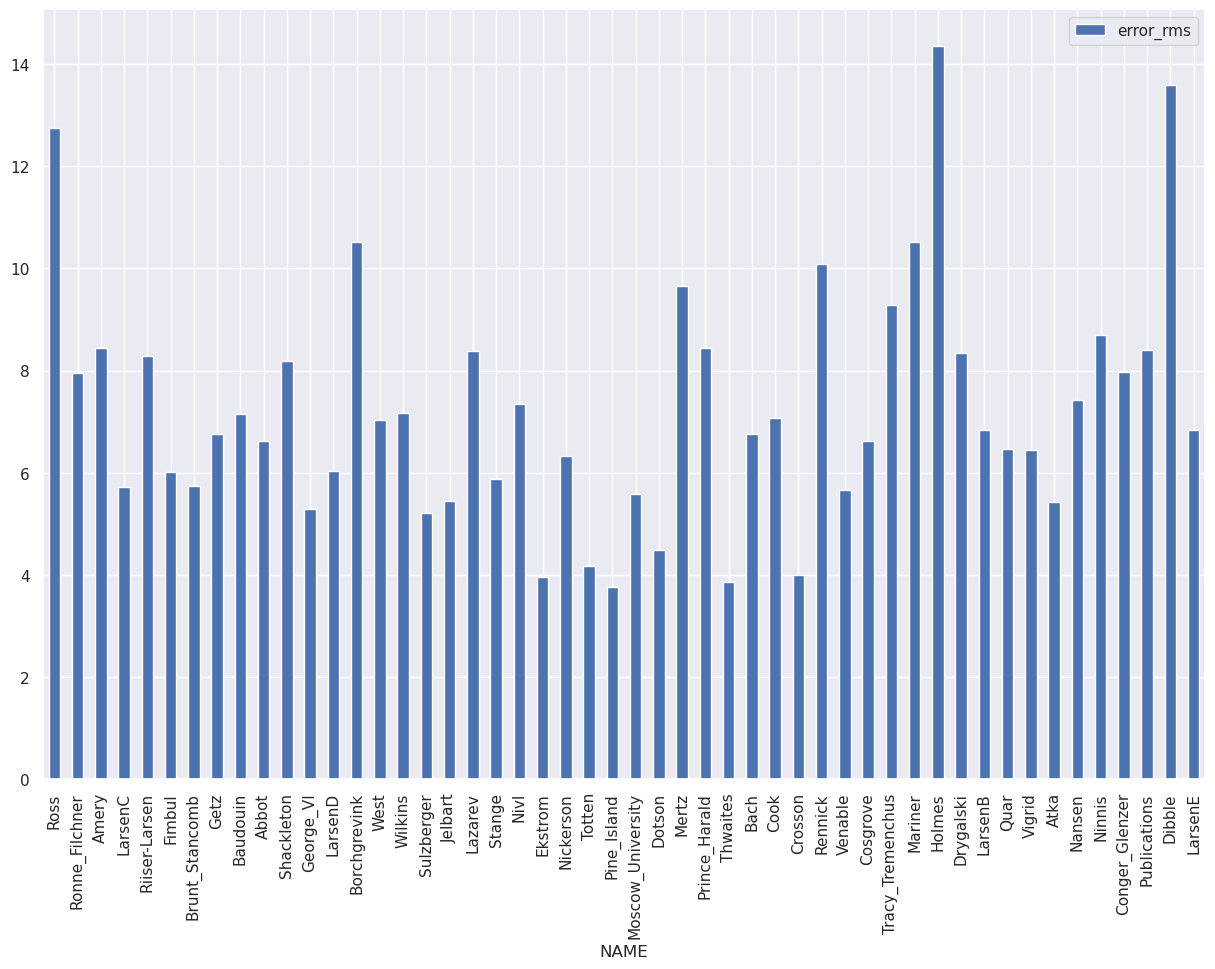

In [119]:
# stat1 = "error_stdev"
stat1 = "error_rms"
# ax = ice_shelf_stats_gdf.iloc[0:50].sort_values([stat1], ascending=False).plot(
ax = ice_shelf_stats_gdf.iloc[0:50].plot(
    x="NAME",
    y=[stat1],
    kind="bar",
    figsize=(15, 10),
    # width=1.2,
)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

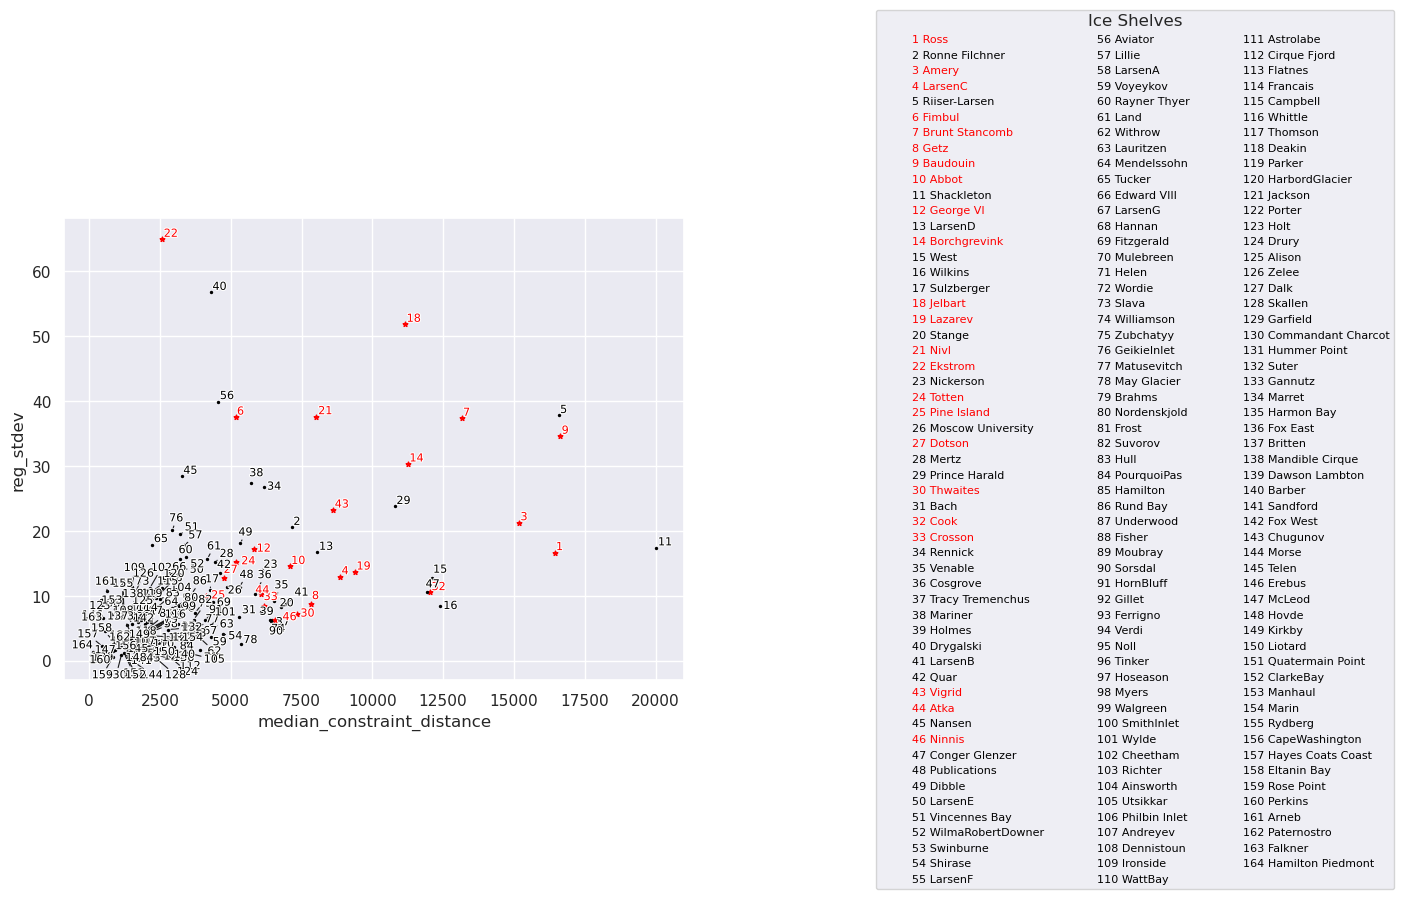

In [7]:
ice_shelf_stats.add_shelves_to_ensembles(
    x="median_constraint_distance",
    y="reg_stdev",
    ice_shelves=ice_shelf_stats_gdf,
    # legend=False,
    legend_cols=3
)


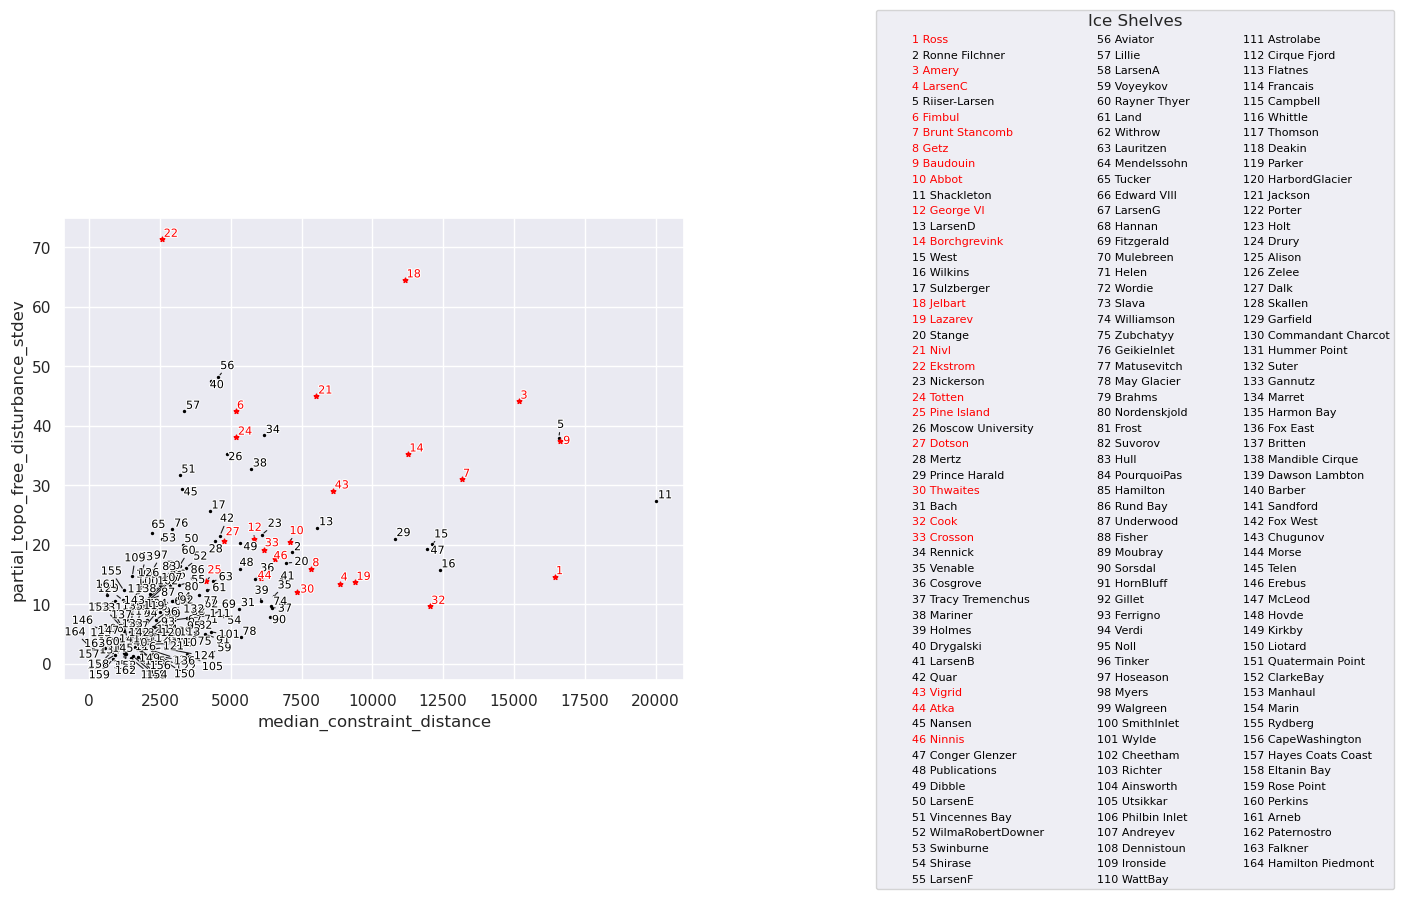

In [8]:
ice_shelf_stats.add_shelves_to_ensembles(
    x="median_constraint_distance",
    y="partial_topo_free_disturbance_stdev",
    ice_shelves=ice_shelf_stats_gdf,
    # legend=False,
    legend_cols=3
)


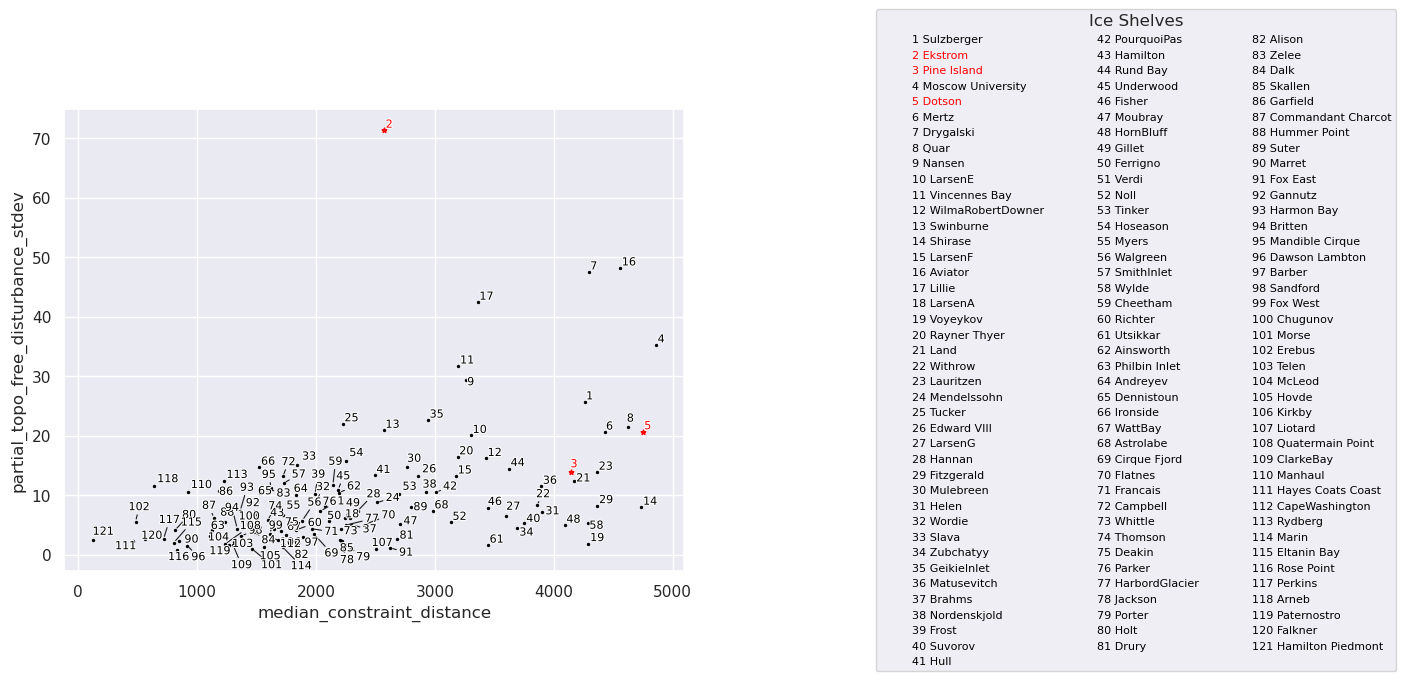

In [80]:
ice_shelf_stats.add_shelves_to_ensembles(
    x="median_constraint_distance",
    y="partial_topo_free_disturbance_stdev",
    ice_shelves=ice_shelf_stats_gdf[
        (ice_shelf_stats_gdf.median_constraint_distance < 5e3)
        # (ice_shelf_stats_gdf.partial_topo_free_disturbance_stdev < 10)
        ],
    # legend=False,
    legend_cols=3
)


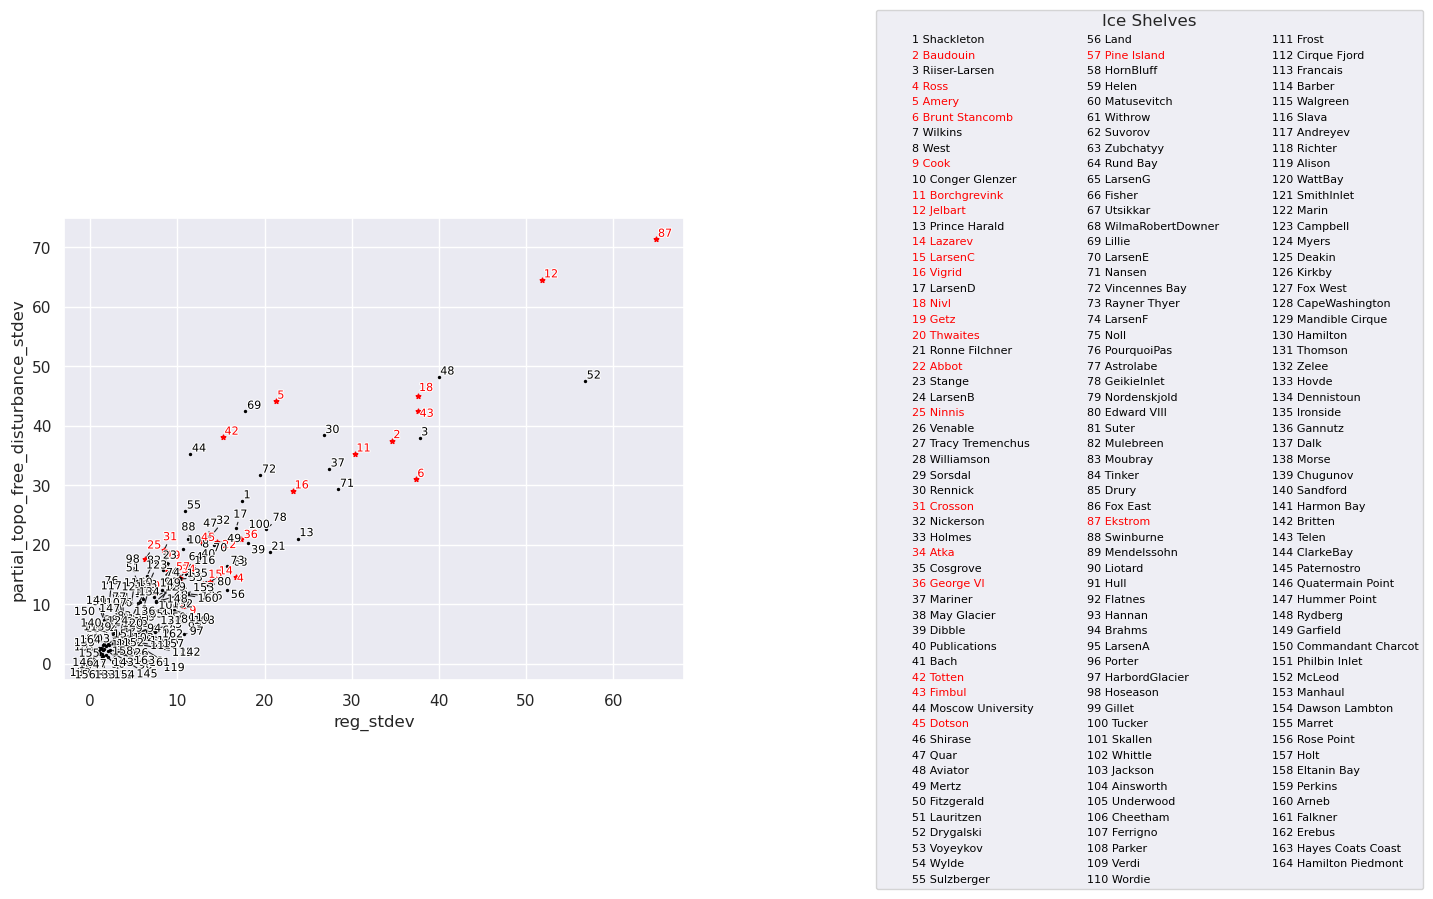

In [9]:
ice_shelf_stats.add_shelves_to_ensembles(
    x="reg_stdev",
    y="partial_topo_free_disturbance_stdev",
    ice_shelves=ice_shelf_stats_gdf.sort_values("median_constraint_distance", ascending=False),
    # legend=False,
    legend_cols=3
)

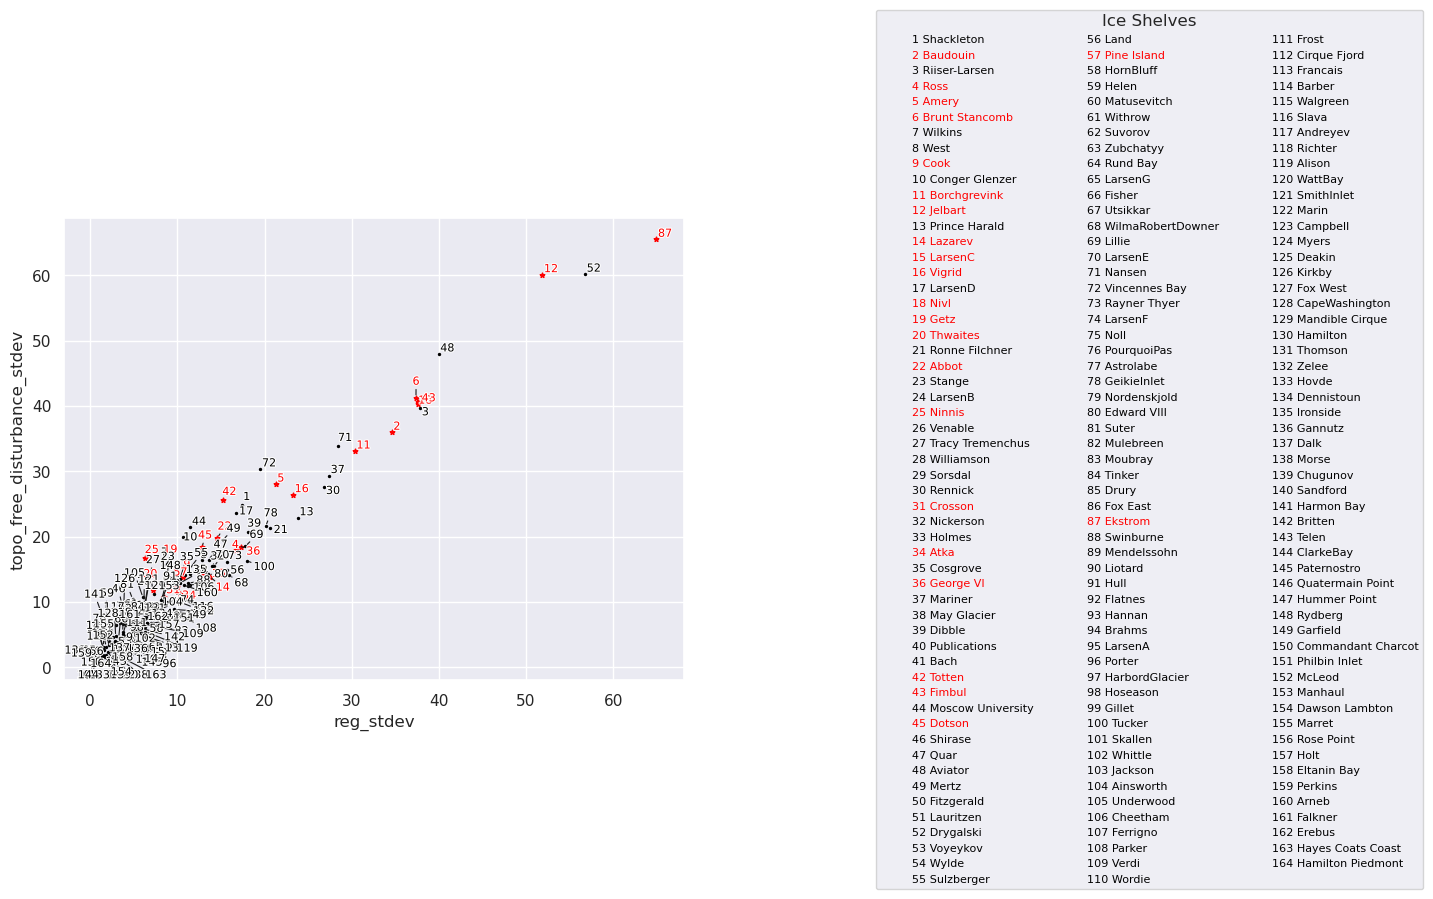

In [10]:
ice_shelf_stats.add_shelves_to_ensembles(
    x="reg_stdev",
    y="topo_free_disturbance_stdev",
    ice_shelves=ice_shelf_stats_gdf.sort_values("median_constraint_distance", ascending=False),
    # legend=False,
    legend_cols=3
)

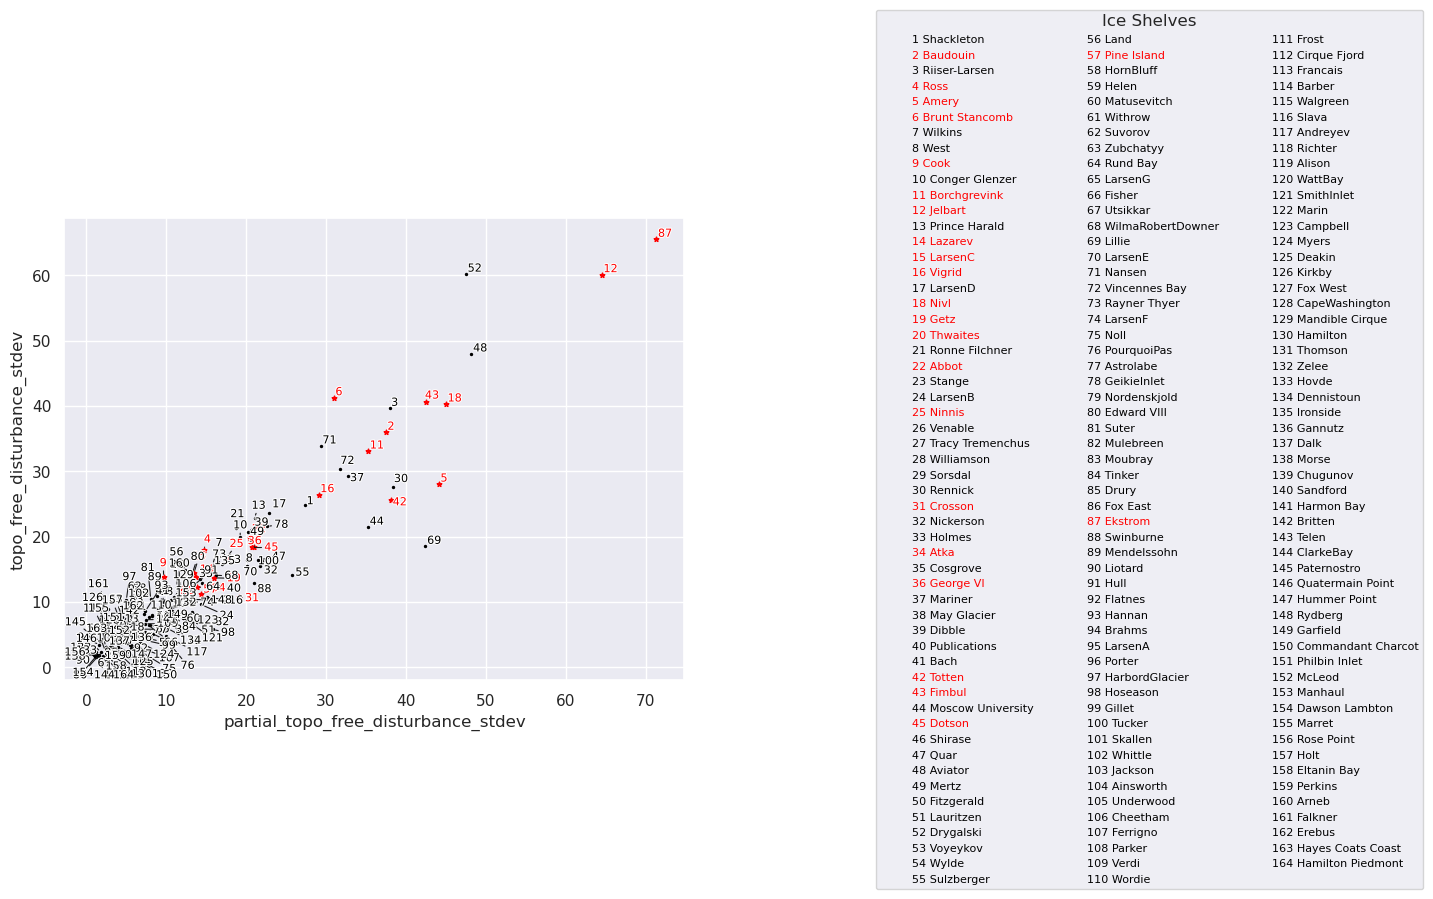

In [11]:
ice_shelf_stats.add_shelves_to_ensembles(
    x="partial_topo_free_disturbance_stdev",
    y="topo_free_disturbance_stdev",
    ice_shelves=ice_shelf_stats_gdf.sort_values("median_constraint_distance", ascending=False),
    # legend=False,
    legend_cols=3
)

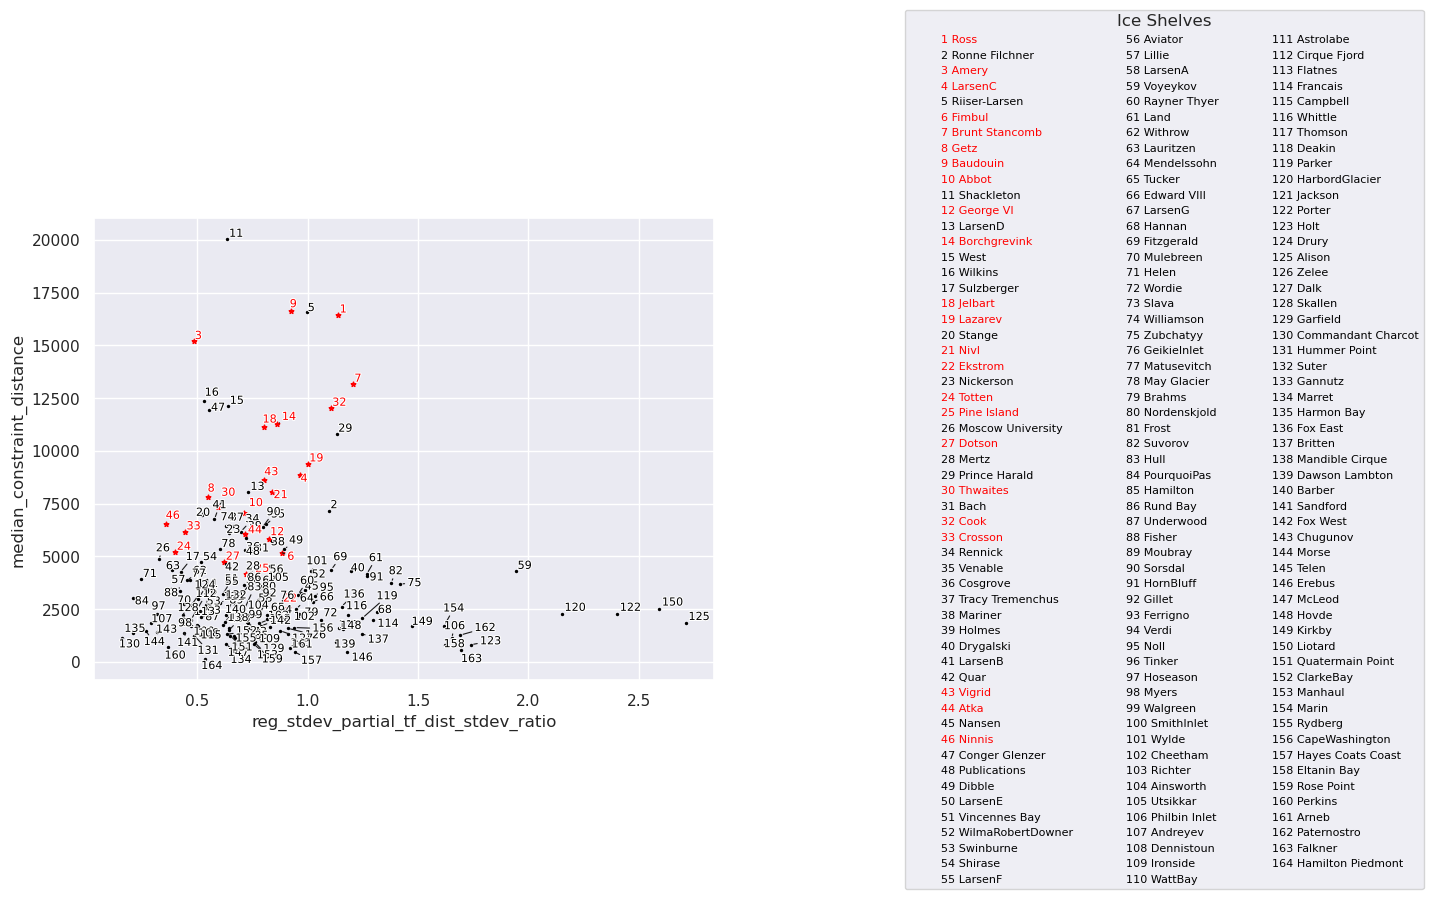

In [12]:
ice_shelf_stats_gdf["reg_stdev_partial_tf_dist_stdev_ratio"] = ice_shelf_stats_gdf.reg_stdev / ice_shelf_stats_gdf.partial_topo_free_disturbance_stdev
ice_shelf_stats.add_shelves_to_ensembles(
    x="reg_stdev_partial_tf_dist_stdev_ratio",
    y="median_constraint_distance",
    ice_shelves=ice_shelf_stats_gdf,#.sort_values("median_constraint_distance", ascending=False),
    # legend=False,
    legend_cols=3
)

In [48]:
ice_shelf_stats_gdf.iloc[0:50].describe()

area  median_constraint_distance  \
count      50.000000                   50.000000   
mean    30128.320000                 7999.860299   
std     88679.068961                 3999.344176   
min      1167.000000                 2575.246893   
25%      2739.250000                 5287.454323   
50%      6034.500000                 6529.226334   
75%     22378.500000                10438.336023   
max    480428.000000                20027.080067   

       gravity_disturbance_root_mean_square  \
count                             50.000000   
mean                              53.732181   
std                               34.412651   
min                                9.340275   
25%                               30.268811   
50%                               44.201719   
75%                               76.013387   
max                              201.145771   

       gravity_disturbance_mean_absolute  gravity_disturbance_stdev  \
count                          50.000000                  50.000000   
mean                           49.021361                  24.886536   
std                            34.321131                  13.665965   
min                             7.476216                   9.309275   
25%                            26.446064                  14.909286   
50%                            38.724095                  20.436779   
75%                            70.177640                  32.860419   
max                           197.268255                  71.319719   

       partial_topo_free_disturbance_root_mean_square  \
count                                       50.000000   
mean                                        53.344386   
std                                         34.063590   
min                                          9.270249   
25%                                         30.169644   
50%                                         43.584543   
75%                                         75.176981   
max                                        199.406055   

       partial_topo_free_disturbance_mean_absolute  \
count                                    50.000000   
mean                                     48.627288   
std                                      33.974518   
min                                       7.432635   
25%                                      26.394123   
50%                                      37.899255   
75%                                      69.136501   
max                                     195.678909   

       partial_topo_free_disturbance_stdev  \
count                            50.000000   
mean                             24.870874   
std                              13.620954   
min                               9.232088   
25%                              14.947504   
50%                              20.542541   
75%                              32.314281   
max                              71.336115   

       topo_free_disturbance_root_mean_square  \
count                               50.000000   
mean                                44.341447   
std                                 32.824812   
min                                 11.934935   
25%                                 20.658247   
50%                                 34.759345   
75%                                 57.217836   
max                                169.581628   

       topo_free_disturbance_mean_absolute  ...  starting_gravity_stdev  \
count                            50.000000  ...               50.000000   
mean                             39.710697  ...               10.517392   
std                              32.265128  ...                6.276438   
min                              10.182088  ...                2.789238   
25%                              18.116454  ...                5.773325   
50%                              29.386555  ...                8.518188   
75%                              52.662412  ...               13.341900   
max                      

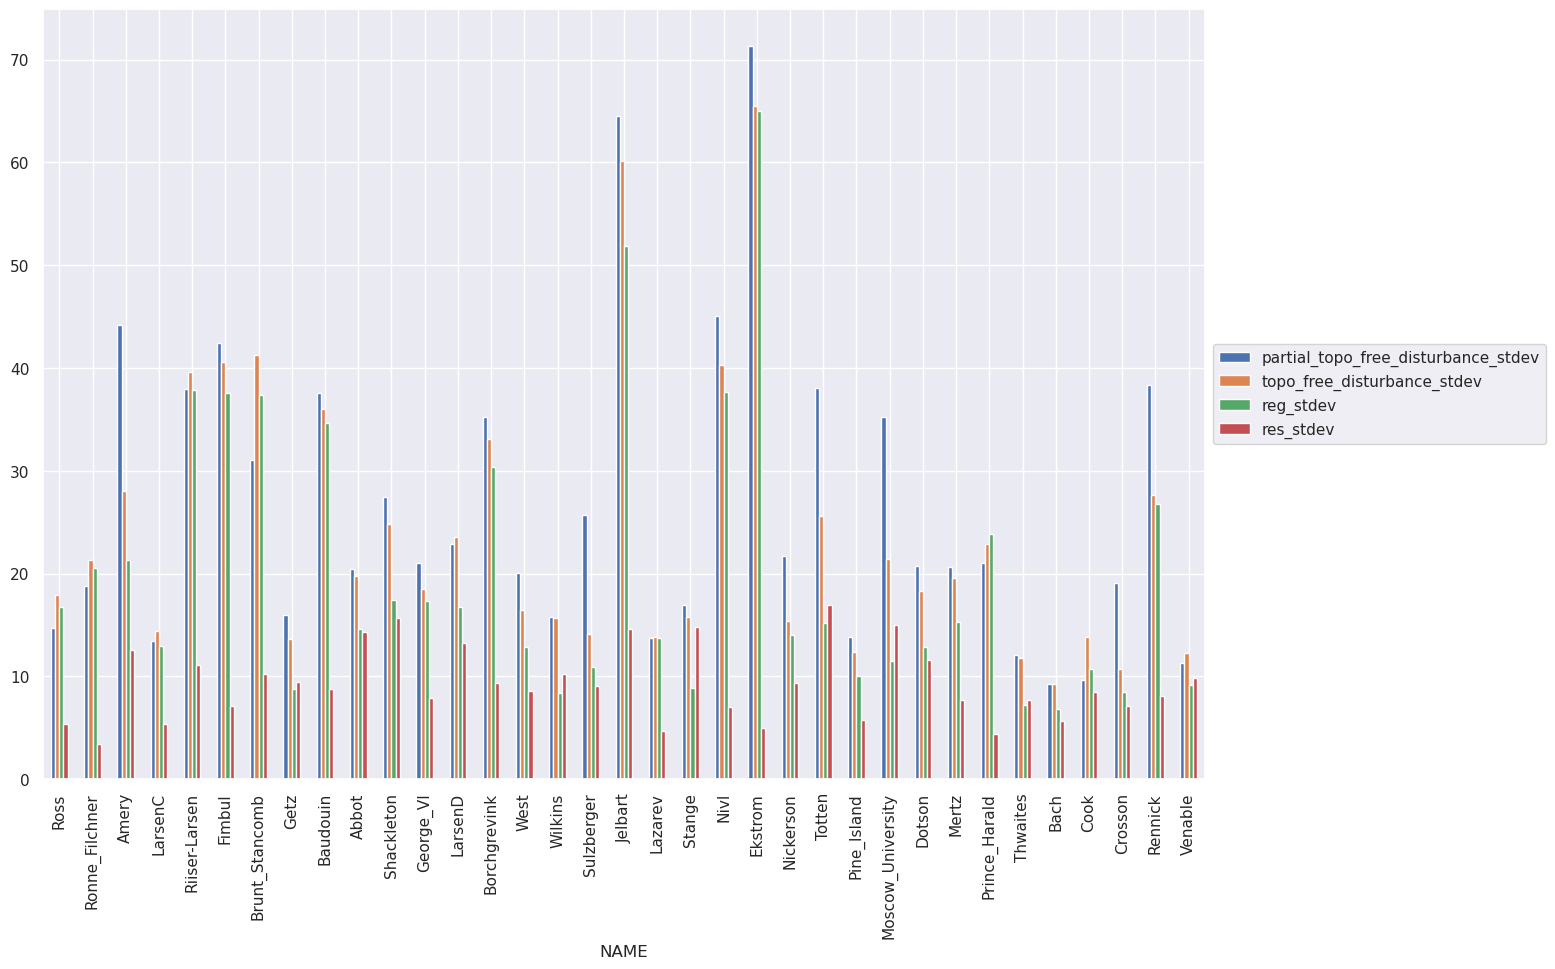

In [14]:
ax = ice_shelf_stats_gdf.iloc[0:35].plot.bar(
    x="NAME",
    y=[
        'partial_topo_free_disturbance_stdev',
        'topo_free_disturbance_stdev',
        'reg_stdev',
        'res_stdev',
    ],
    # width=1.5,
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# if reg_stdev is low, either means
#   1) regional strength is low
#   2) or there are lots of
#      constraints and due to constraint point minimization, the estimated region is == misfit

# if reg_stdev is high, means regional strength is high no matter what

# if topo_free_disturbance_stdev is low, regional is low no matter what

# if partial_topo_free_disturbance_stdev is high, either means
#   1) regional strength is high
#   2) or true bathymetry is contributing lots to the signal

# if misfit (topo_free_disturbance_stdev) is low regional is low no matter what

# if misfit is high, either means
#   1) regional strength is high
#   2) starting bathymetry is very bad and contributing to the signal
#       this is only possible if few constraints points!

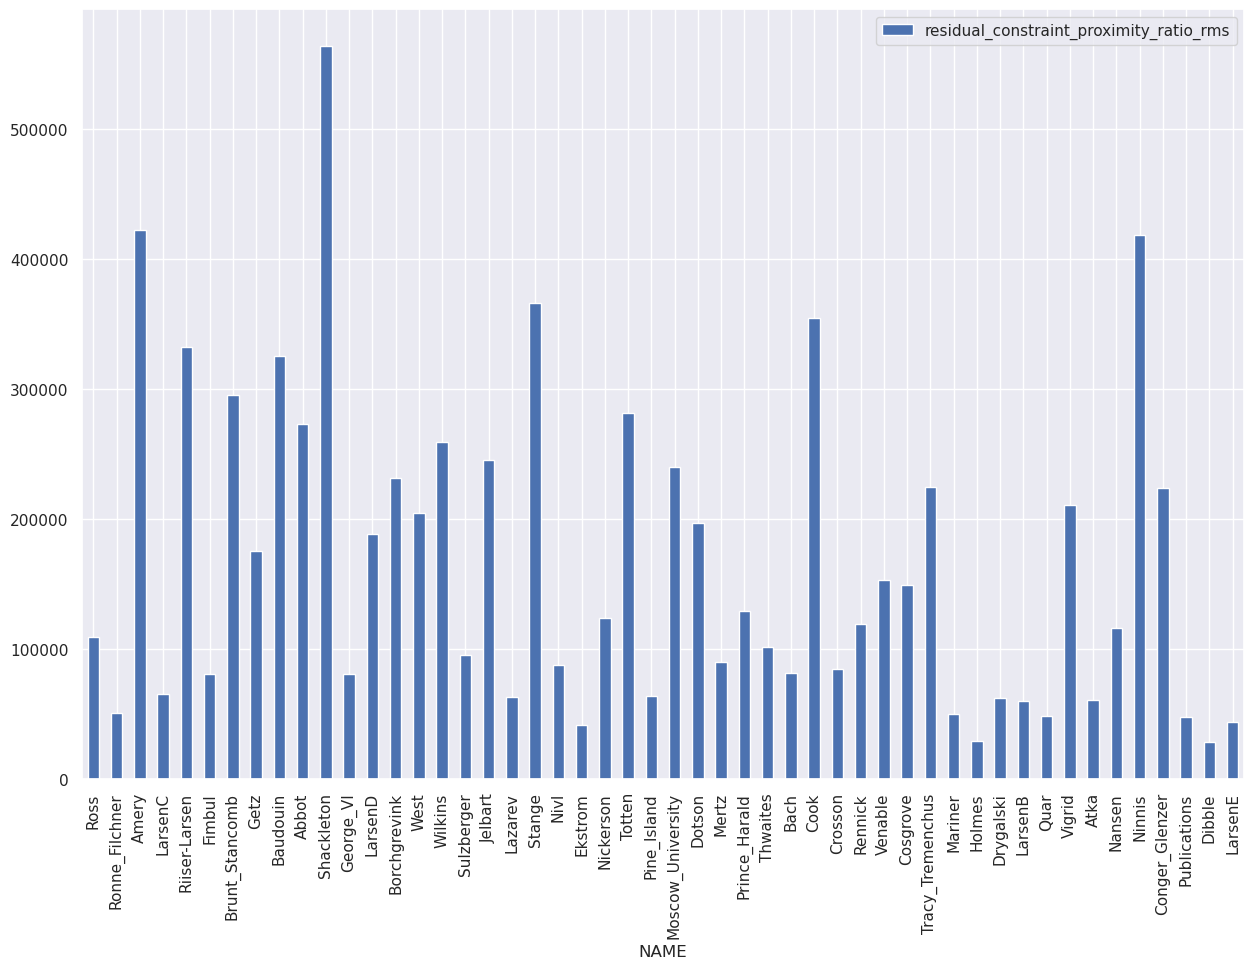

In [73]:
stat1 = "residual_constraint_proximity_ratio_rms"
# ax = ice_shelf_stats_gdf.iloc[0:50].sort_values([stat1], ascending=False).plot(
ax = ice_shelf_stats_gdf.iloc[0:50].plot(
    x="NAME",
    y=[stat1],
    kind="bar",
    figsize=(15, 10),
    # width=1.2,
)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

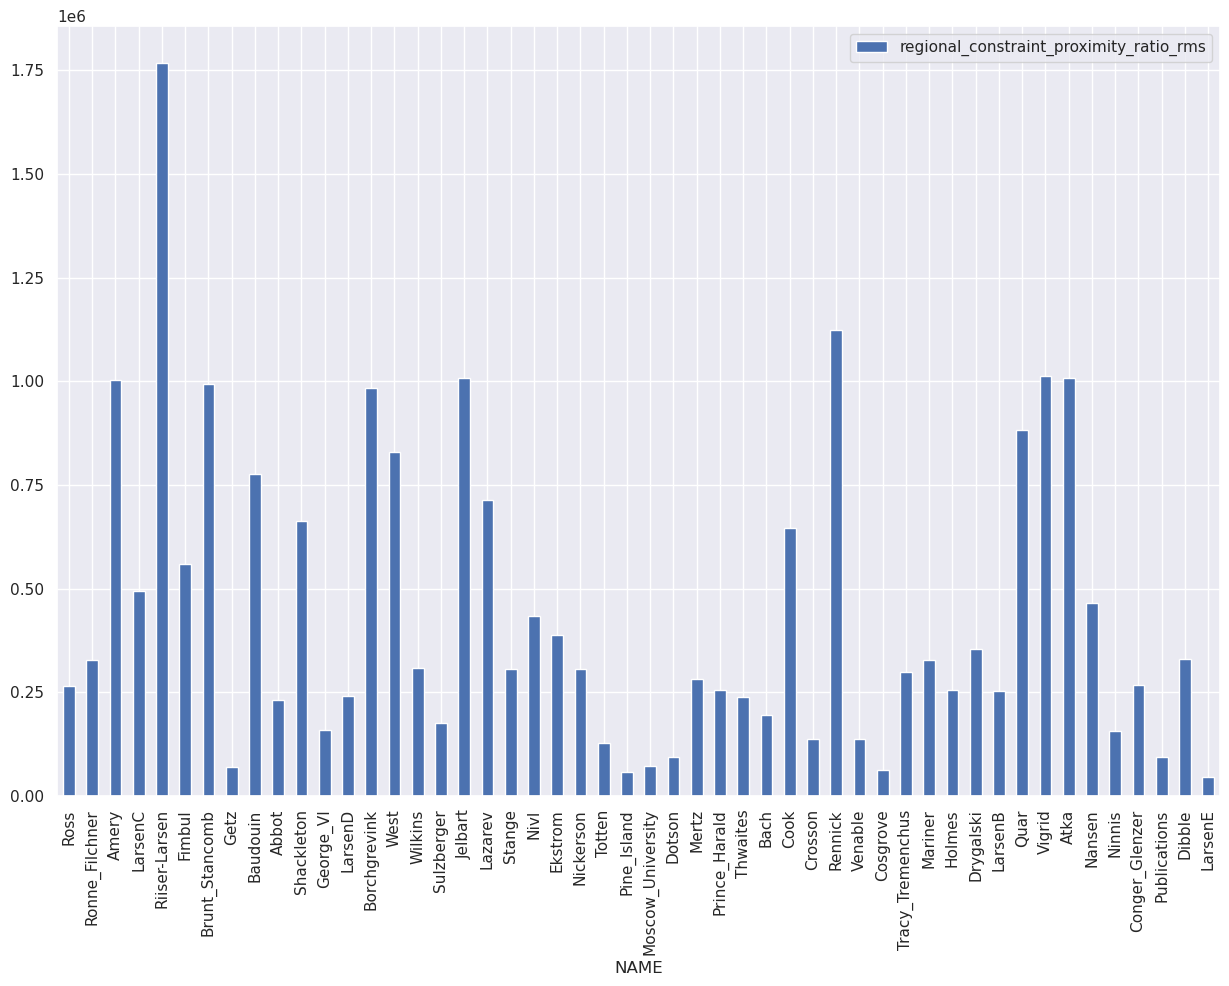

In [72]:
stat1 = "regional_constraint_proximity_ratio_rms"
# ax = ice_shelf_stats_gdf.iloc[0:50].sort_values([stat1], ascending=False).plot(
ax = ice_shelf_stats_gdf.iloc[0:50].plot(
    x="NAME",
    y=[stat1],
    kind="bar",
    figsize=(15, 10),
    # width=1.2,
)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

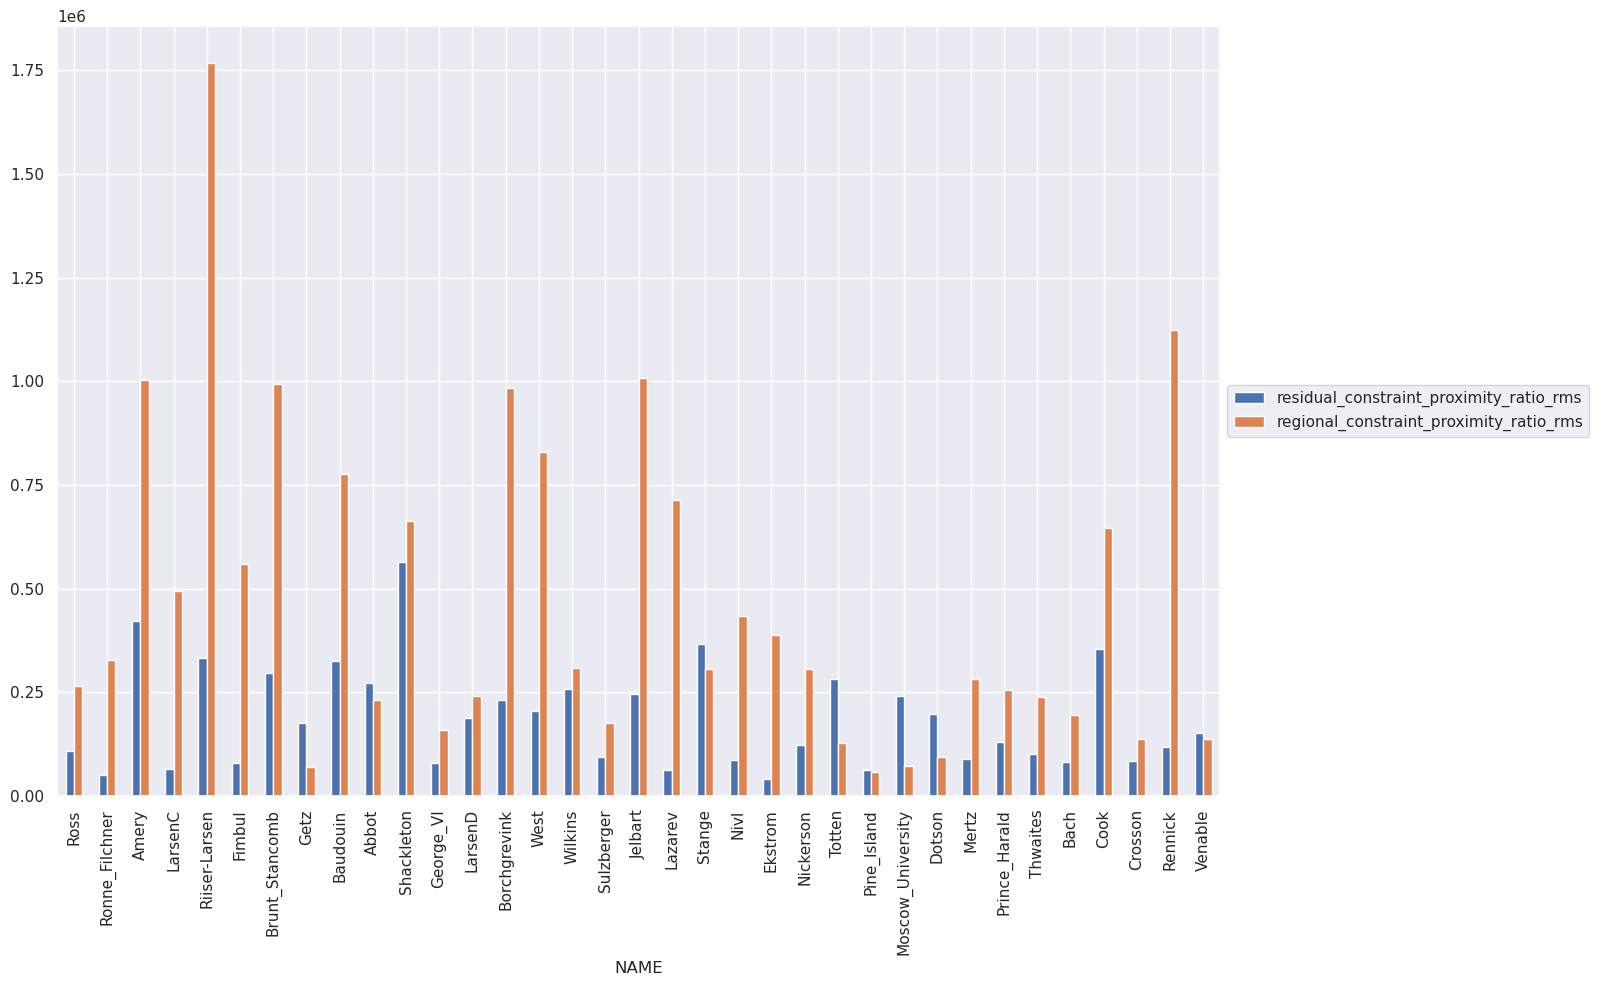

In [74]:
ax = ice_shelf_stats_gdf.iloc[0:35].plot.bar(
    x="NAME",
    y=[
        'residual_constraint_proximity_ratio_rms',
        'regional_constraint_proximity_ratio_rms',
    ],
    # width=1.5,
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

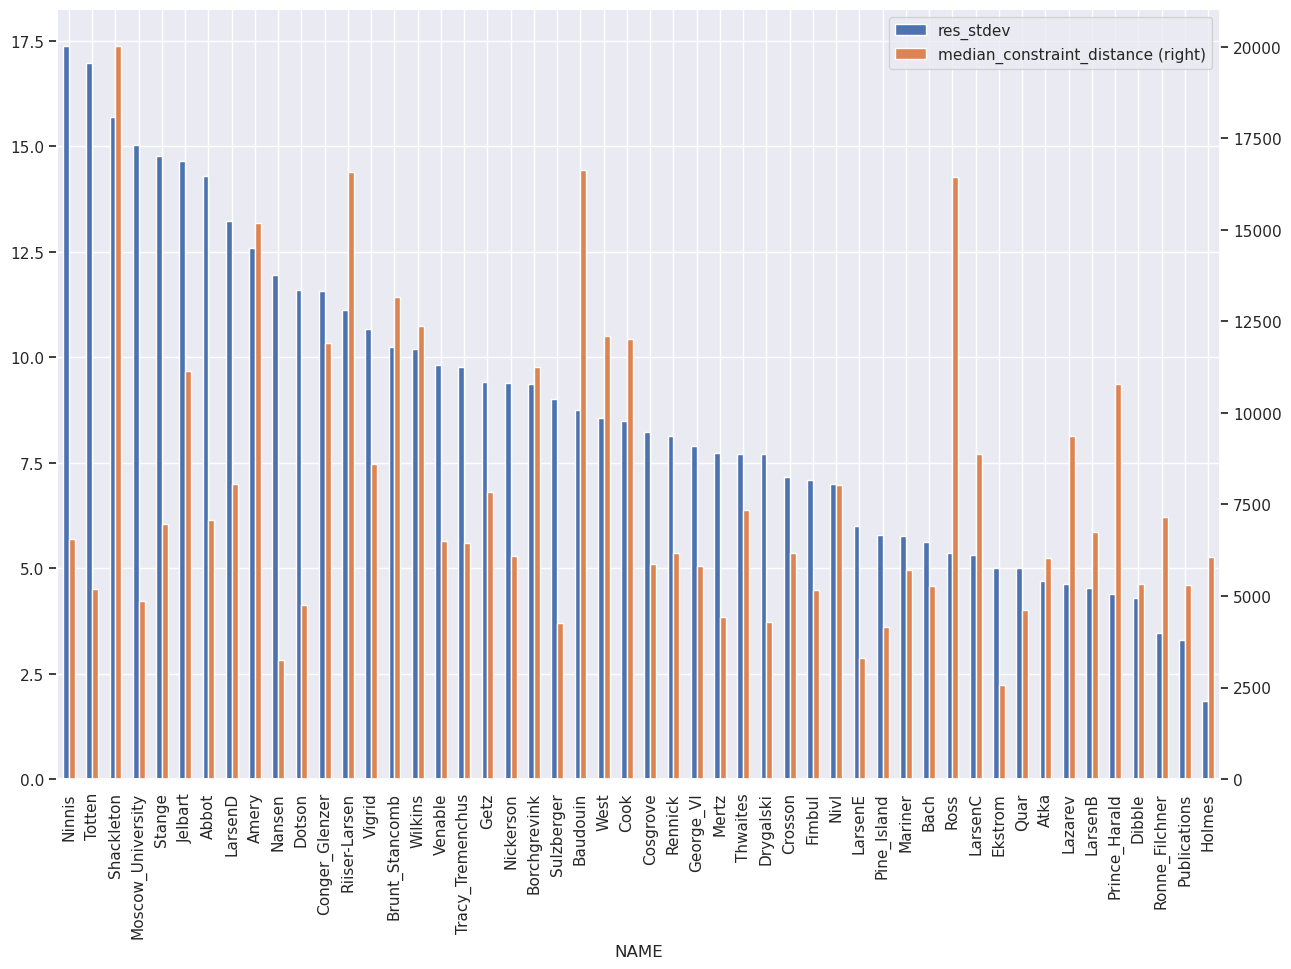

In [21]:
stat1 = "res_stdev"
stat2 = "median_constraint_distance"

ax = ice_shelf_stats_gdf.iloc[0:50].sort_values([stat1], ascending=False).plot(
    x="NAME",
    y=[stat1, stat2,],
    secondary_y=stat2,
    kind="bar",
    figsize=(15, 10),
    # width=1.2,
)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

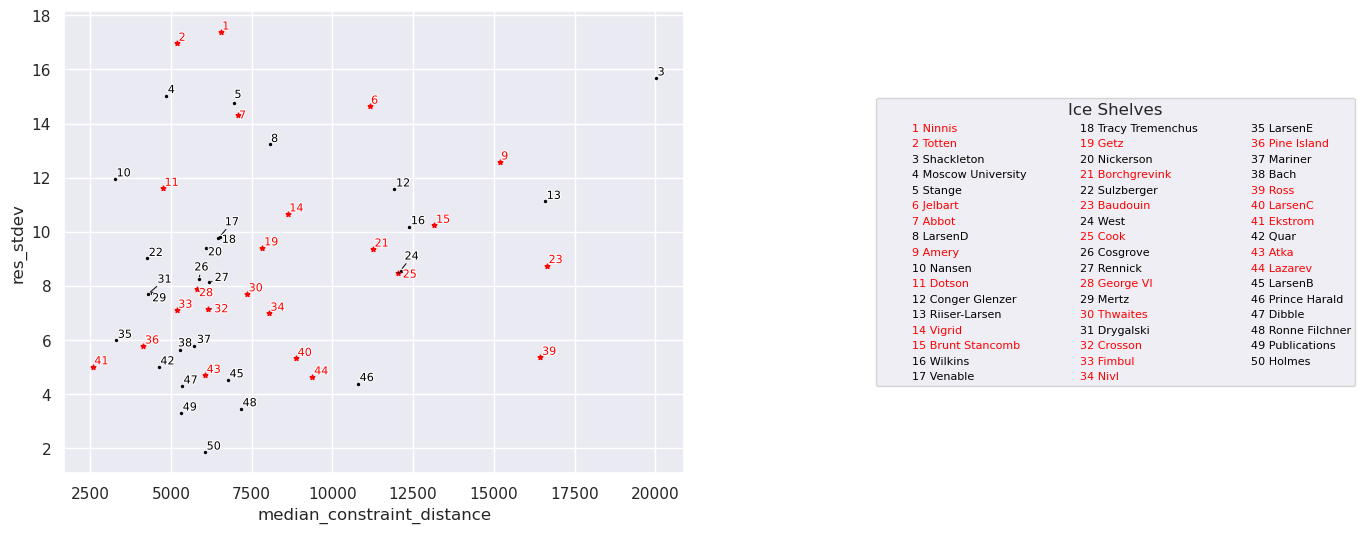

In [22]:
ice_shelf_stats.add_shelves_to_ensembles(
    x="median_constraint_distance",
    y="res_stdev",
    ice_shelves=ice_shelf_stats_gdf.iloc[0:50].sort_values("res_stdev", ascending=False),
    # legend=False,
    legend_cols=3
)

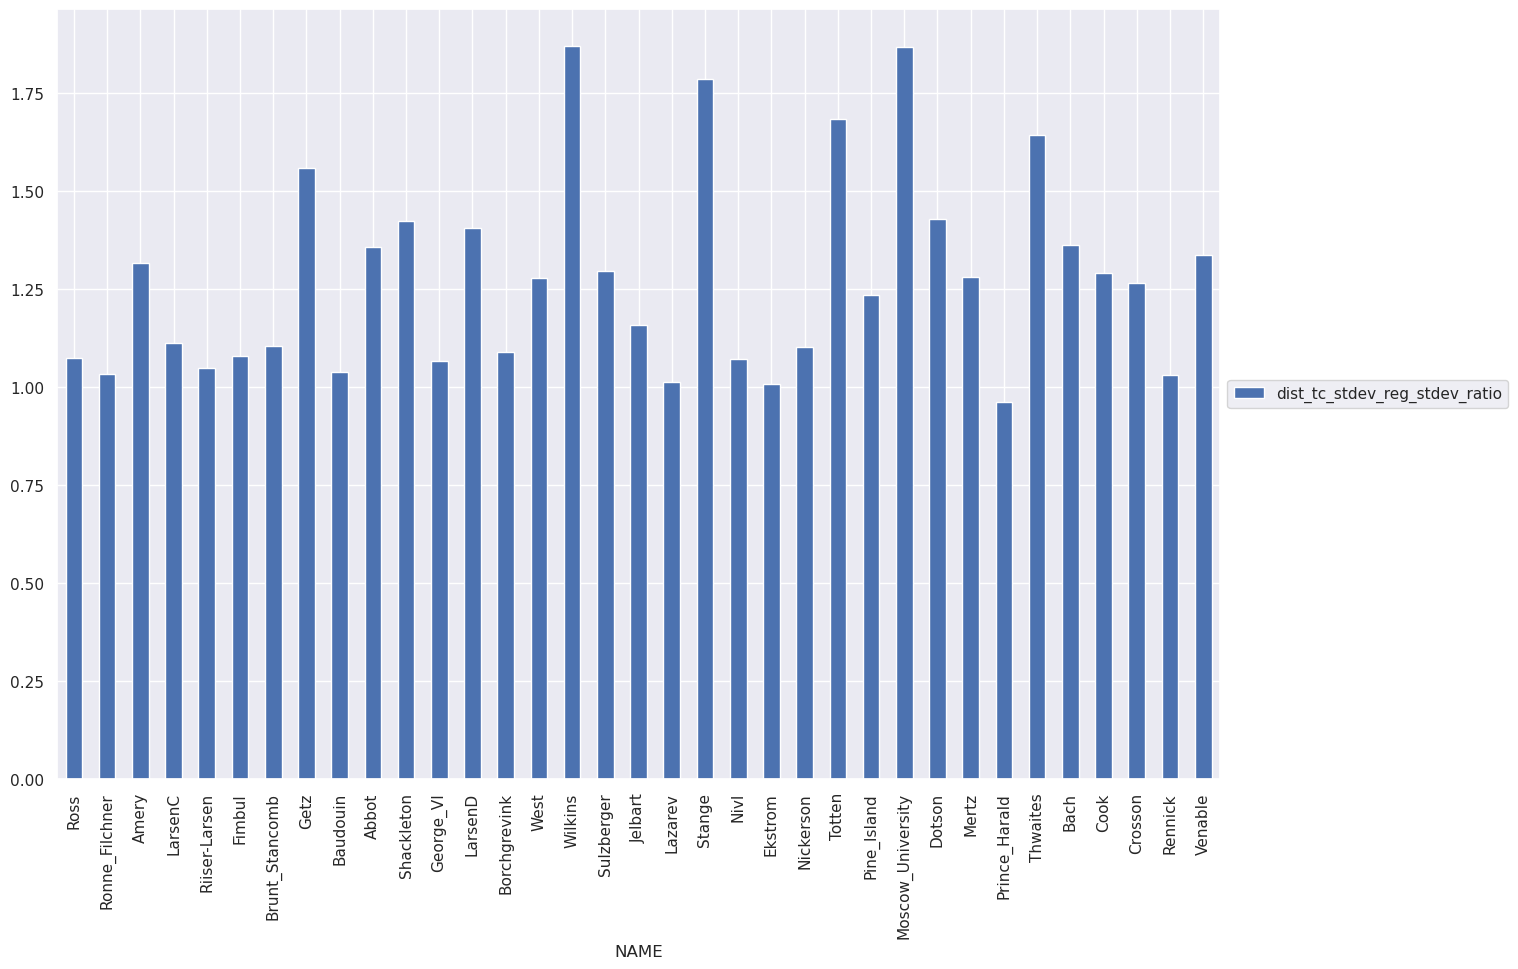

In [49]:
ice_shelf_stats_gdf["dist_tc_stdev_reg_stdev_ratio"] = ice_shelf_stats_gdf.topo_free_disturbance_stdev / ice_shelf_stats_gdf.reg_stdev
ax = ice_shelf_stats_gdf.iloc[0:35].plot.bar(
    x="NAME",
    y=["dist_tc_stdev_reg_stdev_ratio"],
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

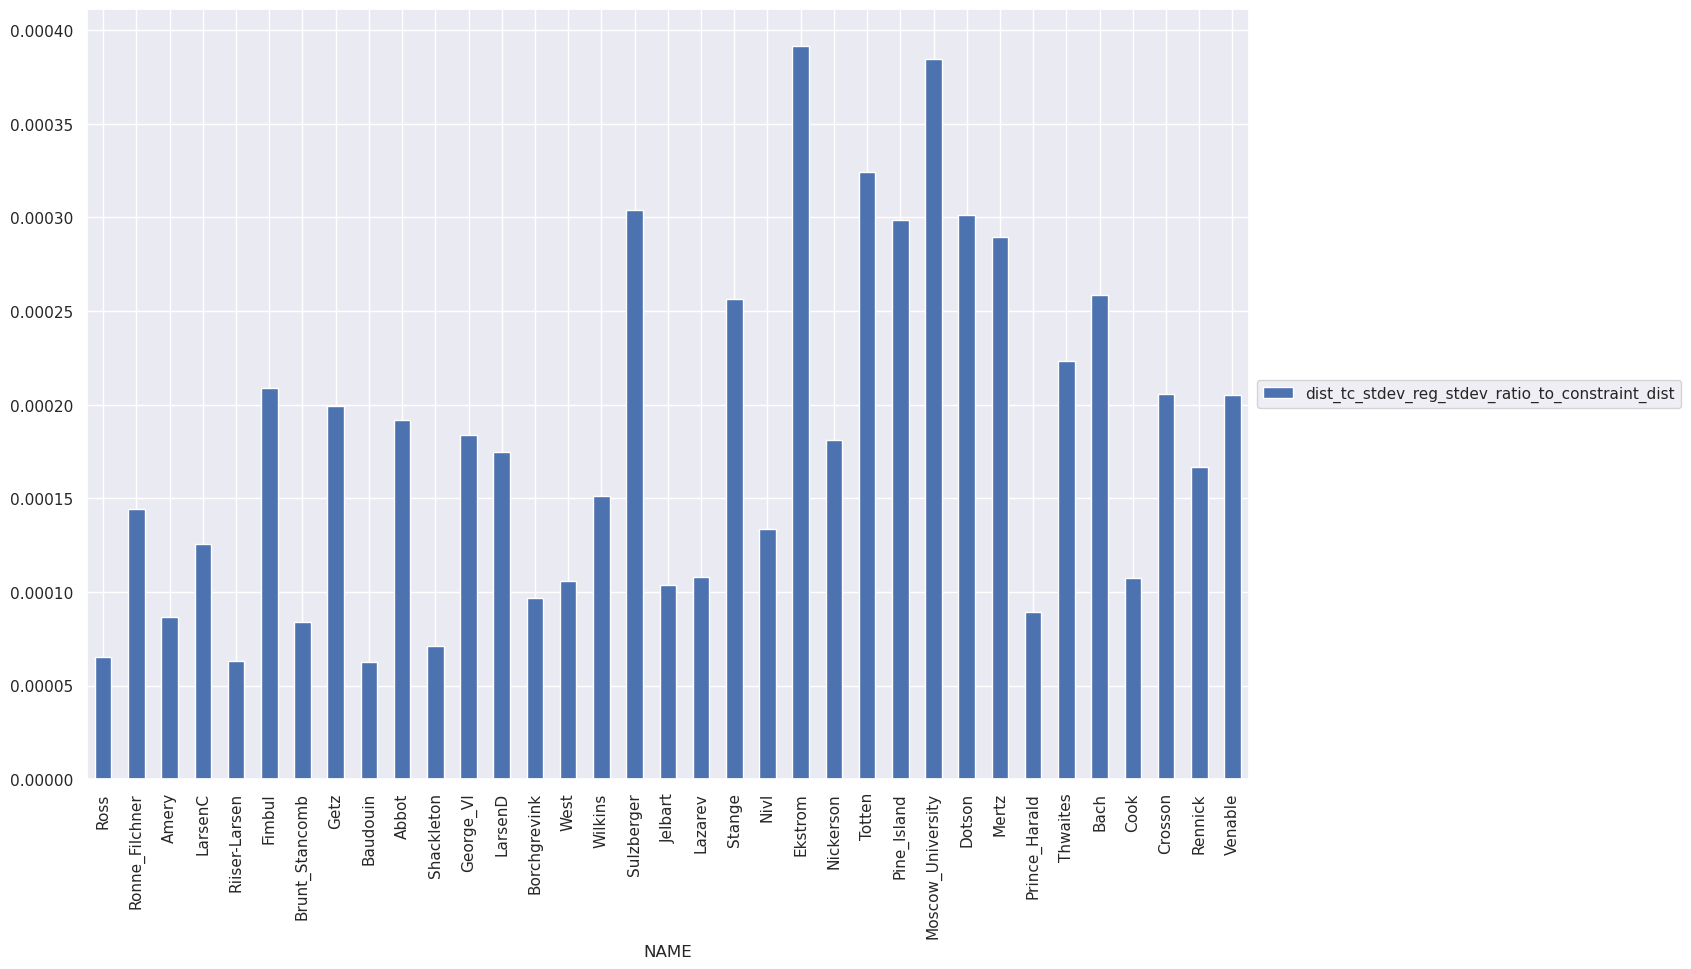

In [50]:
ice_shelf_stats_gdf["dist_tc_stdev_reg_stdev_ratio_to_constraint_dist"] = ice_shelf_stats_gdf.dist_tc_stdev_reg_stdev_ratio / ice_shelf_stats_gdf.median_constraint_distance
ax = ice_shelf_stats_gdf.iloc[0:35].plot.bar(
    x="NAME",
    y=["dist_tc_stdev_reg_stdev_ratio_to_constraint_dist"],
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

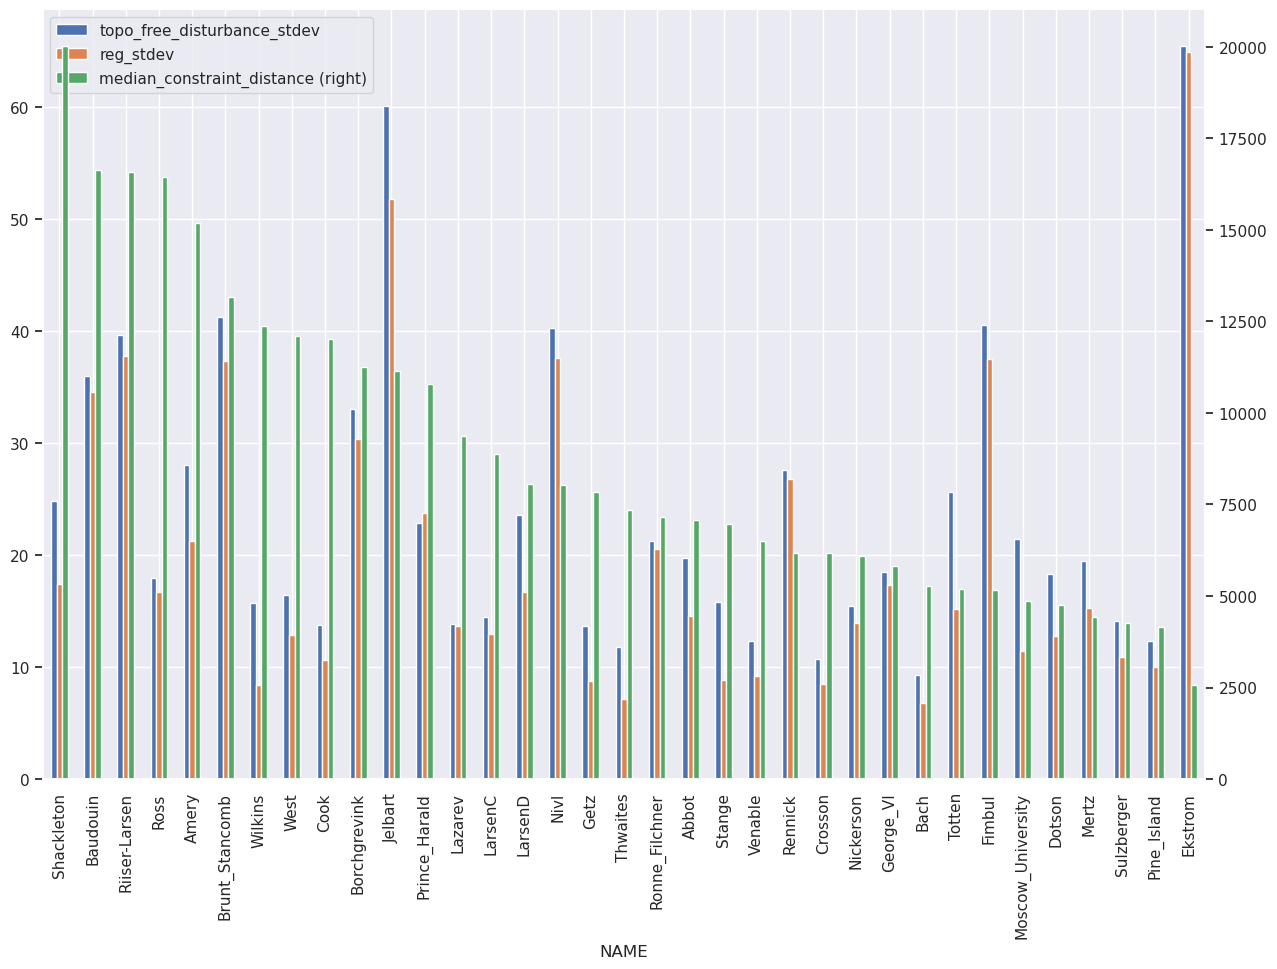

In [51]:
stat1 = "topo_free_disturbance_stdev"
stat2 = "reg_stdev"
stat3 = "median_constraint_distance"

ax = ice_shelf_stats_gdf.iloc[0:35].sort_values([stat3], ascending=False).plot(
    x="NAME",
    y=[stat1, stat2, stat3],
    secondary_y=stat3,
    kind="bar",
    figsize=(15, 10),
    # width=1.2,
)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

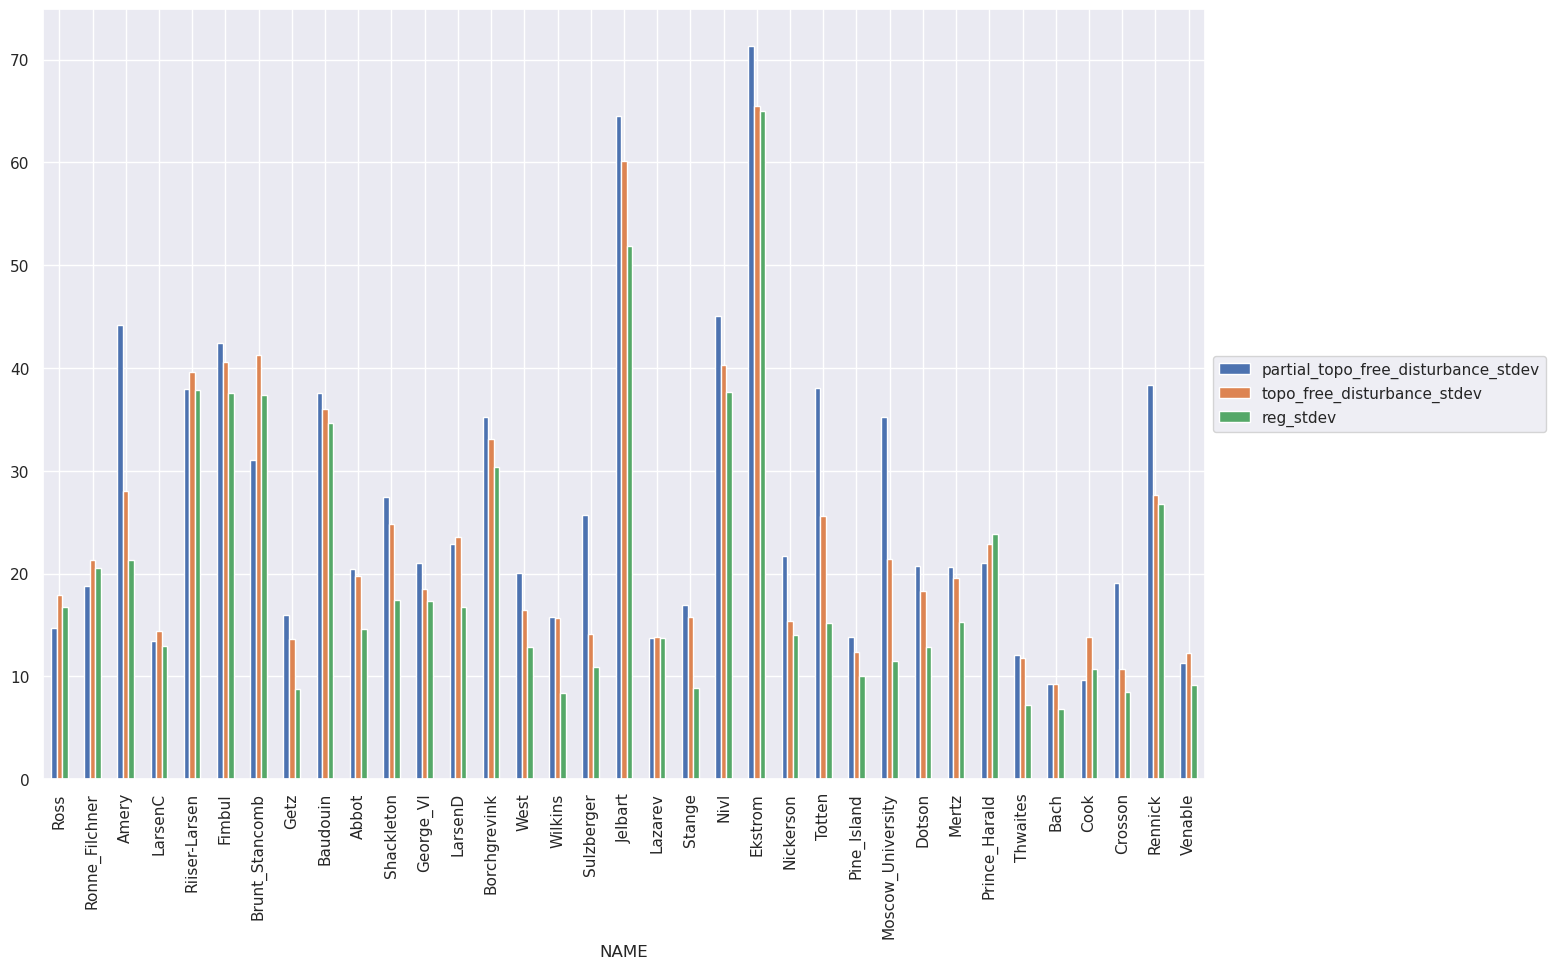

In [53]:
# ice_shelf_stats_gdf[""]

ax = ice_shelf_stats_gdf.iloc[0:35].plot.bar(
    x="NAME",
    y=[
        'partial_topo_free_disturbance_stdev',
        'topo_free_disturbance_stdev',
        'reg_stdev',
    ],
    # width=1.5,
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## Predict column values to add shelves to ensemble plots

In [57]:
ensemble_path = (
    # "../../results/Ross_Sea_08_constraint_spacing_vs_regional_strength_ensemble"
    # "../../results/Ross_Sea_08_constraint_spacing_vs_regional_strength_ensemble_pygmt_gridding"
    # "../../results/Ross_Sea_08_constraint_spacing_vs_regional_strength_ensemble_100"
    # "../../results/Ross_Sea_08_constraint_spacing_vs_regional_strength_ensemble_100_lims_from_shelves"
    "../../results/Ross_Sea_08_constraint_spacing_vs_regional_strength_ensemble_100_lims_from_all_shelves_logscale"
)
ensemble_fname = f"{ensemble_path}.csv"

sampled_params_df = pd.read_csv(ensemble_fname)

sampled_params_df.describe()

constraint_numbers  regional_strengths  constraint_spacing  \
count          100.000000          100.000000          100.000000   
mean           162.500000           75.000000            9.704700   
std            184.999727           48.112173            6.016561   
min             10.000000            0.000000            3.021000   
25%             25.000000           33.330000            4.537000   
50%             79.500000           75.000000            7.953500   
75%            242.000000          116.670000           13.895000   
max            600.000000          150.000000           21.915000   

       constraints_per_10000sq_km  constraints_starting_rmse  \
count                  100.000000                 100.000000   
mean                    54.000000                   0.209395   
std                     61.269217                   0.138176   
min                      3.333333                   0.035611   
25%                      8.333333                   0.092417   
50%                     26.500000                   0.164868   
75%                     80.666667                   0.356736   
max                    198.333333                   0.439873   

       starting_bathymetry_mae  starting_bathymetry_rmse  best_damping  \
count               100.000000                100.000000  1.000000e+02   
mean                 19.254174                 29.949894  2.500000e-02   
std                  12.998713                 18.717023  6.973851e-18   
min                   4.870065                  8.686680  2.500000e-02   
25%                   8.232610                 14.792890  2.500000e-02   
50%                  14.032296                 22.063987  2.500000e-02   
75%                  31.848334                 47.645737  2.500000e-02   
max                  43.791536                 64.770163  2.500000e-02   

       constraints_rmse  inversion_rmse  inversion_mae  regional_error  \
count        100.000000      100.000000     100.000000      100.000000   
mean          11.581354       43.916285      31.980506        3.329453   
std           11.325225       55.058725      41.361307        3.765717   
min            0.986883        2.833562       1.857539        0.098943   
25%            2.864058        5.189419       3.730419        0.582722   
50%            6.869746       17.629984      12.510974        1.769887   
75%           17.159857       65.427693      46.151033        4.828143   
max           44.784095      238.136580     184.066545       16.153536   

       regional_rms  gravity_anomaly_rms  regional_stdev  \
count    100.000000           100.000000      100.000000   
mean      15.342446            36.590905       15.343445   
std        9.842112             3.942710        9.842753   
min        0.000000            32.377824        0.000000   
25%        6.818183            32.917397        6.818627   
50%       15.342446            35.507798       15.343445   
75%       23.866709            39.730868       23.868264   
max       30.684892            44.036672       30.686891   

       topo_improvement_rmse  topo_improvement_mae  
count             100.000000            100.000000  
mean              -13.966392            -12.726332  
std                43.913330             33.054220  
min              -173.366417           -140.275009  
25%               -22.980882            -17.422833  
50%                 3.058460              0.733888  
75%                 7.559808              3.854190  
max                59.755062             39.758185

In [58]:
# rescale to be in km
subset_shelves = ice_shelf_stats_gdf.copy()
subset_shelves["median_constraint_distance"] /= 1e3

# subset shelf data within ensemble limits
# subset_shelves = subset_shelves[
#     subset_shelves.median_constraint_distance.between(
#         sampled_params_df.constraint_spacing.min(),
#         sampled_params_df.constraint_spacing.max(),
#     )
#     & subset_shelves.reg_stdev.between(
#         sampled_params_df.regional_stdev.min(),
#         sampled_params_df.regional_stdev.max(),
#     )
# ].reset_index(drop=True)
# constraint_spacing_range = sampled_params_df.constraint_spacing.max() - sampled_params_df.constraint_spacing.min()
# regional_stdev_range = sampled_params_df.regional_stdev.max() - sampled_params_df.regional_stdev.min()

# constraint_spacing_lims = (
#     max(0,sampled_params_df.constraint_spacing.min()-constraint_spacing_range*.25),
#     sampled_params_df.constraint_spacing.max()+constraint_spacing_range*.25,
# )

# regional_stdev_lims = (
#     max(0,sampled_params_df.regional_stdev.min()-regional_stdev_range*.25),
#     sampled_params_df.regional_stdev.max()+regional_stdev_range*.25,
# )
# subset_shelves = subset_shelves[
#     subset_shelves.median_constraint_distance.between(*constraint_spacing_lims)
#     & subset_shelves.reg_stdev.between(*regional_stdev_lims)
# ].reset_index(drop=True)

subset_shelves

NAME    Regions TYPE  \
0                 Ross       West   FL   
1       Ronne_Filchner       West   FL   
2                Amery       East   FL   
3              LarsenC  Peninsula   FL   
4        Riiser-Larsen       East   FL   
..                 ...        ...  ...   
159            Perkins       West   FL   
160              Arneb       East   FL   
161        Paternostro       East   FL   
162            Falkner       East   FL   
163  Hamilton_Piedmont    Islands   FL   

                                              geometry    area  \
0    POLYGON ((-240677.18377991652 -678259.00593521...  480428   
1    POLYGON ((-1006734.8906412432 880592.979674786...  427041   
2    POLYGON ((2134701.4219642165 618463.1172190169...   60797   
3    POLYGON ((-2235724.269360441 1271352.187501361...   47443   
4    POLYGON ((-592166.3173854565 1592824.257663729...   42913   
..                                                 ...     ...   
159  POLYGON ((-1129608.7530223199 -1201300.7339383...       7   
160  POLYGON ((333867.8249121742 -1897953.452471011...       6   
161  POLYGON ((824294.4850947502 -2115301.606811986...       6   
162  POLYGON ((425350.5316694485 -1726631.609486937...       5   
163  POLYGON ((-1589132.0271998756 -582392.52463378...       5   

     median_constraint_distance  gravity_disturbance_root_mean_square  \
0                     16.438369                             44.934094   
1                      7.164803                             41.514238   
2                     15.183931                             54.607713   
3                      8.870497                             14.847744   
4                     16.583215                             53.516817   
..                          ...                                   ...   
159                    0.718792                             33.593137   
160                    0.640304                             81.777387   
161                    1.271813                             85.827362   
162                    0.562234                             35.906908   
163                    0.122889                              6.496965   

     gravity_disturbance_mean_absolute  gravity_disturbance_stdev  \
0                            42.487759                  14.663219   
1                            37.167851                  18.769872   
2                            40.000478                  44.217952   
3                            12.388092                  13.588458   
4                            49.075067                  37.949582   
..                                 ...                        ...   
159                          33.434542                   3.571592   
160                          81.122847                  11.153281   
161                          85.823263                   0.896751   
162                          35.777142                   3.341045   
163                           6.101628                   2.577001   

     partial_topo_free_disturbance_root_mean_square  ...  reg_mean_absolute  \
0                                         43.662103  ...          12.043670   
1                                         41.429561  ...          28.234343   
2                                         55.333792  ...          34.850414   
3                                         14.444266  ...          36.063085   
4                                         52.971480  ...          68.814102   
..                                              ...  ...                ...   
159                                       33.666794  ...          25.013858   
160                                       79.323918  ...          71.836873   
161                                       87.111418  ...          68.722377   
162                                       36.851665  ...          37.567379   
163                                        5.892665  ...          15.854364   

     reg_stdev  res_root_mean_square  res_mean_absolute     res_s

In [63]:
sampled_params_df

constraint_numbers  regional_strengths  \
0                   10                0.00   
1                   10               16.67   
2                   10               33.33   
3                   10               50.00   
4                   10               66.67   
..                 ...                 ...   
95                 600               83.33   
96                 600              100.00   
97                 600              116.67   
98                 600              133.33   
99                 600              150.00   

                              constraint_points_fname  constraint_spacing  \
0   ../../results/Ross_Sea_08_constraint_spacing_v...              21.915   
1   ../../results/Ross_Sea_08_constraint_spacing_v...              21.915   
2   ../../results/Ross_Sea_08_constraint_spacing_v...              21.915   
3   ../../results/Ross_Sea_08_constraint_spacing_v...              21.915   
4   ../../results/Ross_Sea_08_constraint_spacing_v...              21.915   
..                                                ...                 ...   
95  ../../results/Ross_Sea_08_constraint_spacing_v...               3.021   
96  ../../results/Ross_Sea_08_constraint_spacing_v...               3.021   
97  ../../results/Ross_Sea_08_constraint_spacing_v...               3.021   
98  ../../results/Ross_Sea_08_constraint_spacing_v...               3.021   
99  ../../results/Ross_Sea_08_constraint_spacing_v...               3.021   

    constraints_per_10000sq_km  constraints_starting_rmse  \
0                     3.333333                   0.035611   
1                     3.333333                   0.035611   
2                     3.333333                   0.035611   
3                     3.333333                   0.035611   
4                     3.333333                   0.035611   
..                         ...                        ...   
95                  198.333333                   0.399204   
96                  198.333333                   0.399204   
97                  198.333333                   0.399204   
98                  198.333333                   0.399204   
99                  198.333333                   0.399204   

                            starting_bathymetry_fname  \
0   ../../results/Ross_Sea_08_constraint_spacing_v...   
1   ../../results/Ross_Sea_08_constraint_spacing_v...   
2   ../../results/Ross_Sea_08_constraint_spacing_v...   
3   ../../results/Ross_Sea_08_constraint_spacing_v...   
4   ../../results/Ross_Sea_08_constraint_spacing_v...   
..                                                ...   
95  ../../results/Ross_Sea_08_constraint_spacing_v...   
96  ../../results/Ross_Sea_08_constraint_spacing_v...   
97  ../../results/Ross_Sea_08_constraint_spacing_v...   
98  ../../results/Ross_Sea_08_constraint_spacing_v...   
99  ../../results/Ross_Sea_08_constraint_spacing_v...   

                                starting_prisms_fname  \
0   ../../results/Ross_Sea_08_constraint_spacing_v...   
1   ../../results/Ross_Sea_08_constraint_spacing_v...   
2   ../../results/Ross_Sea_08_constraint_spacing_v...   
3   ../../results/Ross_Sea_08_constraint_spacing_v...   
4   ../../results/Ross_Sea_08_constraint_spacing_v...   
..                                                ...   
95  ../../results/Ross_Sea_08_constraint_spacing_v...   
96  ../../results/Ross_Sea_08_constraint_spacing_v...   
97  ../../results/Ross_Sea_08_constraint_spacing_v...   
98  ../../results/Ross_Sea_08_constraint_spacing_v...   
99  ../../results/Ross_Sea_08_constraint_spacing_v...   

    starting_bathymetry_mae  starting_bathymetry_rmse  ... constraints_rmse  \
0                 43.791536                 64.770163  ...         4.239252   
1                 43.791536                 64.770163  ...         3.888718   
2                 43.791536                 64.770163  ...         5.337806   
3                 43.791536                 64.770163  ...         6.829119   
4                 43.791536 

In [64]:
# predict constraints_per_10000sq_km from constraint_spacing column
# shelves_predicted = gravity_processing.skl_predict_trend(
#     data_to_fit=sampled_params_df,
#     cols_to_fit=["constraint_spacing", "constraints_per_10000sq_km"],
#     data_to_predict=subset_shelves,
#     cols_to_predict=["median_constraint_distance","constraints_per_10000sq_km"],
#     degree=3,
# )
# predict inversion_mae from constraint_spacing and regional strength columns
# for ensemble data, regional strength is regional_stdev
# for shelf data, regional strength is best approximated with either
# 1) reg_stdev (calculated regional from constraint point minimization)
# 2) partial_topo_free_disturbance_stdev (disturbance corrected for ice and water)
# predict_on = "reg_stdev"
# predict_on = "partial_topo_free_disturbance_stdev"
predict_on = "topo_free_disturbance_stdev"

shelves_predicted = gravity_processing.verde_predict_trend(
    data_to_fit=sampled_params_df,
    cols_to_fit=["constraint_spacing", "regional_stdev", "inversion_mae"],
    data_to_predict=subset_shelves,
    cols_to_predict=["median_constraint_distance", predict_on, "inversion_mae"],
    degree=3,
)
# predict topo_improvement_mae
shelves_predicted = gravity_processing.verde_predict_trend(
    data_to_fit=sampled_params_df,
    cols_to_fit=["constraint_spacing", "regional_stdev", "topo_improvement_mae"],
    data_to_predict=shelves_predicted,
    cols_to_predict=["median_constraint_distance", predict_on, "topo_improvement_mae"],
    degree=3,
)
shelves_predicted.head()

NAME    Regions TYPE  \
0            Ross       West   FL   
1  Ronne_Filchner       West   FL   
2           Amery       East   FL   
3         LarsenC  Peninsula   FL   
4   Riiser-Larsen       East   FL   

                                            geometry    area  \
0  POLYGON ((-240677.18377991652 -678259.00593521...  480428   
1  POLYGON ((-1006734.8906412432 880592.979674786...  427041   
2  POLYGON ((2134701.4219642165 618463.1172190169...   60797   
3  POLYGON ((-2235724.269360441 1271352.187501361...   47443   
4  POLYGON ((-592166.3173854565 1592824.257663729...   42913   

   median_constraint_distance  gravity_disturbance_root_mean_square  \
0                   16.438369                             44.934094   
1                    7.164803                             41.514238   
2                   15.183931                             54.607713   
3                    8.870497                             14.847744   
4                   16.583215                             53.516817   

   gravity_disturbance_mean_absolute  gravity_disturbance_stdev  \
0                          42.487759                  14.663219   
1                          37.167851                  18.769872   
2                          40.000478                  44.217952   
3                          12.388092                  13.588458   
4                          49.075067                  37.949582   

   partial_topo_free_disturbance_root_mean_square  ...  res_root_mean_square  \
0                                       43.662103  ...              5.376152   
1                                       41.429561  ...              3.460521   
2                                       55.333792  ...             14.573418   
3                                       14.444266  ...              5.318446   
4                                       52.971480  ...             11.198799   

   res_mean_absolute  res_stdev  error_root_mean_square  error_mean_absolute  \
0           3.418230   5.361364               12.748633            12.352106   
1           1.855342   3.460078                7.952294             7.754940   
2          10.280951  12.580467                8.435324             8.420287   
3           3.987351   5.316355                5.718122             5.574310   
4           8.061273  11.124435                8.282689             8.251957   

   error_stdev  dist_tc_stdev_reg_stdev_ratio  \
0     3.154937                       1.075135   
1     1.760702                       1.034586   
2     0.503457                       1.316438   
3     1.274370                       1.114014   
4     0.712841                       1.048287   

   dist_tc_stdev_reg_stdev_ratio_to_constraint_dist  inversion_mae  \
0                                          0.000065      80.810803   
1                                          0.000144      22.198059   
2                                          0.000087     111.343103   
3                                          0.000126      22.157506   
4                                          0.000063     173.897301   

   topo_improvement_mae  
0            -45.539040  
1             -8.717367  
2            -78.704058  
3             -4.607854  
4           -138.335934  

[5 rows x 31 columns]

In [66]:
# fig, ax = plt.subplots()

# for ind, (i, row) in enumerate(shelves_predicted.iterrows()):
#     ax.scatter(
#         row.median_constraint_distance,
#         row[predict_on],
#         # marker="x",
#         # color=sns.color_palette(None, len(shelves_predicted))[ind],
#         color="black",
#         # s=100,
#         marker=f"${ind+1}$",
#         label=row.NAME,
#     )
# ax.set_xlim(ax.get_xlim()[::-1])
# ax.set_xlabel("Constraints distance (km)")
# ax.set_ylabel("Estimated regional field strength (mGal)")
# ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), fontsize=8,)

In [44]:
# fig, ax = plt.subplots()


# for ind, (i, row) in enumerate(shelves_predicted.iterrows()):
#     ax.scatter(
#         row.constraints_per_10000sq_km,
#         row[predict_on],
#         # marker="x",
#         # color=sns.color_palette(None, len(shelves_predicted))[ind],
#         color="black",
#         marker=f"${ind+1}$",
#         label=row.NAME,
#     )
# # ax.set_xlim(ax.get_xlim()[::-1])
# ax.set_xlabel("Constraints per 10000 $km^2$")
# ax.set_ylabel("Estimated regional field strength (mGal)")
# ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), fontsize=8,)

## Plot ice shelves which fall in range of Ensemble #7 limits

In [67]:
# subset shelf data within ensemble limits
predicted_subset = shelves_predicted[
    shelves_predicted.median_constraint_distance.between(
        sampled_params_df.constraint_spacing.min(),
        sampled_params_df.constraint_spacing.max(),
    )
    & shelves_predicted[predict_on].between(
        sampled_params_df.regional_stdev.min(),
        sampled_params_df.regional_stdev.max(),
    )
].reset_index(drop=True)

# plot only the largest shelves which fall in the ensemble limits
predicted_subset = predicted_subset[predicted_subset.NAME.isin(ice_shelves.iloc[0:100].NAME)]
predicted_subset.NAME.unique()

array(['Ross', 'Ronne_Filchner', 'Amery', 'LarsenC', 'Getz', 'Abbot',
       'Shackleton', 'George_VI', 'LarsenD', 'West', 'Wilkins',
       'Sulzberger', 'Lazarev', 'Stange', 'Nickerson', 'Totten',
       'Pine_Island', 'Moscow_University', 'Dotson', 'Mertz',
       'Prince_Harald', 'Thwaites', 'Bach', 'Cook', 'Crosson', 'Rennick',
       'Venable', 'Cosgrove', 'Tracy_Tremenchus', 'Mariner', 'Holmes',
       'LarsenB', 'Quar', 'Vigrid', 'Atka', 'Ninnis', 'Conger_Glenzer',
       'Publications', 'Dibble', 'LarsenE', 'Vincennes_Bay',
       'WilmaRobertDowner', 'Shirase', 'LarsenF', 'Lillie', 'Voyeykov',
       'Rayner_Thyer', 'Land', 'Withrow', 'Lauritzen', 'LarsenG',
       'Fitzgerald', 'Helen', 'Williamson', 'Zubchatyy', 'Matusevitch',
       'May_Glacier', 'Suvorov', 'Rund_Bay', 'Fisher', 'Sorsdal',
       'HornBluff', 'Noll'], dtype=object)

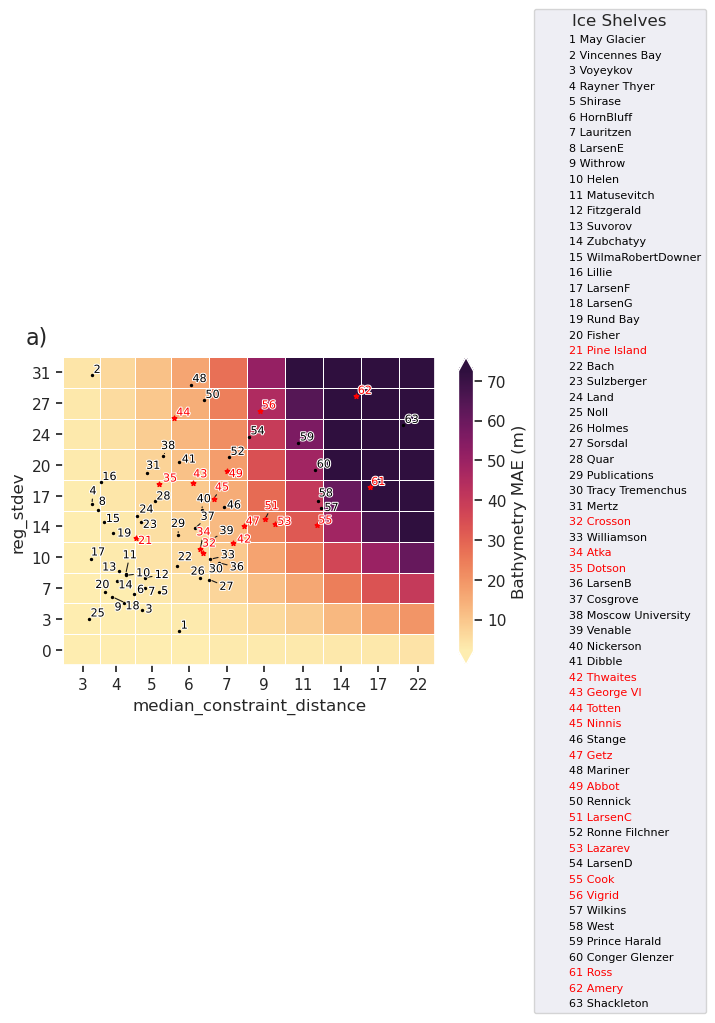

In [91]:
fig = RIS_plotting.plot_2var_ensemble(
    sampled_params_df,
    figsize=(6, 4),
    x="constraint_spacing",
    x_title="Constraint distance (km)",
    # x="number_of_constraints",
    # x_title="Number of constraints",
    # x="constraints_per_10000sq_km",
    # x_title="Constraints per 10000 $km^2$",
    # y="regional_rms",
    # y_title="Regional field strength (mGal)",
    y="regional_stdev",
    y_title="Regional field standard deviation (mGal)",
    background="inversion_mae",
    background_title="Bathymetry MAE (m)",
    # background_robust=True,
    # background_cpt_lims=(0, 80),
    background_cpt_lims=polar_utils.get_min_max(
        sampled_params_df.inversion_mae,
        robust=True,
        robust_percentiles=(0.05, 0.85),
    ),
    logx=True,
    # flipx=True,
)
ax = fig.get_axes()[0]

plt.gcf().text(0.1, 0.9, "a)", fontsize=16, va="bottom", ha="right")

# specify x ticks
ax.grid(True)
vals = list(sampled_params_df.constraint_spacing.unique()[::1])
ax.set_xticks(vals)
ax.set_xticklabels([round(x) for x in vals])
ax.tick_params(
    axis='both', which='both', length=5, bottom=True, left=True,
)
for axis in [ax.xaxis]:
    formatter = mpl.ticker.ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)
    # axis.set_minor_formatter(formatter)
    axis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))

plt.minorticks_off()


# specify y ticks
yvals = list(sampled_params_df.regional_stdev.unique())#[::2])
# yvals.append(sampled_params_df.regional_stdev.unique()[-1])
ax.set_yticks(yvals)
ax.set_yticklabels([round(x) for x in yvals])
ax.tick_params(
    axis='both', which='both', length=5, bottom=True, left=True,
)



# sort by predicted inversion_mae
predicted_subset = predicted_subset.sort_values("inversion_mae")
# sort by predicted topo_improvement_mae
# predicted_subset = predicted_subset.sort_values("topo_improvement_mae", ascending=False)

add_shelves_to_ensembles(
    predict_on,
    ax,
    predicted_subset
)

In [ ]:
fig = RIS_plotting.plot_2var_ensemble(
    sampled_params_df,
    figsize=(6, 4),
    x="constraints_per_10000sq_km",
    x_title="Constraints per 10000 $km^2$",
    y="regional_stdev",
    y_title="Regional field standard deviation (mGal)",
    background="inversion_mae",
    background_title="Bathymetry MAE (m)",
    # plot_title="Constraint spacing vs regional strength",
    background_robust=True,
)
ax = fig.get_axes()[0]

bbox = dict(facecolor="lightgray", boxstyle="round")
# plt.gcf().text(0.3, -.05, "many constraints", fontsize=12, va="center", ha="right", bbox=bbox)
# plt.gcf().text(0.6, -.05, "few constraints", fontsize=12, va="center", ha="left", bbox=bbox)
plt.gcf().text(0.1, 0.9, "a)", fontsize=16, va="bottom", ha="right")

# specify x ticks
ax = fig.get_axes()[0]

# zoom out
ax_x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1]*.1*ax_x_range)
ax.grid(True)
vals = list(sampled_params_df.constraints_per_10000sq_km.unique()[::2])
vals.append(sampled_params_df.constraints_per_10000sq_km.unique()[-1])
ax.set_xticks(vals)
ax.set_xticklabels([round(x) for x in vals])
ax.tick_params(
    axis='both', which='both', length=5, bottom=True, left=True,
)

# specify y ticks
ax.set_ylim(ax.get_ylim()[0], regional_stdev_lims[1])
yvals = list(sampled_params_df.regional_stdev.unique()[::2])
yvals.append(sampled_params_df.regional_stdev.unique()[-1])
ax.set_yticks(yvals)
ax.set_yticklabels([round(x) for x in yvals])
ax.tick_params(
    axis='both', which='both', length=5, bottom=True, left=True,
)

ax2 = ax.twiny()
ax2.set_xticks(vals)
vals = [round(x) for x in sampled_params_df.constraint_spacing.unique()][::2]
vals.append(round(sampled_params_df.constraint_spacing.unique()[-1]))
ax2.set_xticklabels(vals)
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("outward", 40))
ax2.set_xlim(ax.get_xlim())
ax2.grid(False)
ax2.set_xlabel("Constraints distance (km)")


# factor = 2
# old_xlims = ax.get_xlim()
# new_xlims = (factor*old_xlims[0], factor*old_xlims[1])
# old_tlocs = ax.get_xticks()
# new_tlocs = [i*factor for i in old_tlocs]
# print("old_xlims {} new_xlims {} old_tlocs {} new_tlocs {}".format(old_xlims, new_xlims, old_tlocs, new_tlocs))
# ax2.set_xticks(new_tlocs)
# ax2.set_xlim(*new_xlims)


In [ ]:
# sort by predicted inversion_mae
subset = subset.sort_values("inversion_mae")
# sort by predicted topo_improvement_mae
# subset = subset.sort_values("topo_improvement_mae", ascending=False)

texts = []
for ind, (i, row) in enumerate(subset.iterrows()):
    # plot shelves as points
    ax.scatter(
        row.constraints_per_10000sq_km,
        row.reg_stdev,
        color="black",
        s=2,
        # alpha=0,
        label=f"{ind+1} {row.NAME.replace('_', ' ')}",
    )
    texts.append(
        ax.text(
            row.constraints_per_10000sq_km,
            row.reg_stdev,
            f"{ind+1}",
            fontsize=8,
            color="black",
            fontweight="normal",
            path_effects=[patheffects.withStroke(linewidth=1.5, foreground="white")],
        )
    )

adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="k", lw=.8),
    ax=ax,
    expand=(1.2, 1.2)
)

ax.legend(
    loc='center left',
    title="Ice Shelves",
    bbox_to_anchor=(1.25, 0.5),
    markerscale=0,
    fontsize=8,
)
fig

In [254]:
# # sort by predicted inversion_mae
# subset = subset.sort_values("inversion_mae")

# for ind, (i, row) in enumerate(subset.iterrows()):
#     # plot shelves as points
#     ax.scatter(
#         row.constraints_per_10000sq_km,
#         row.reg_stdev,
#         color="black",
#         s=2,
#         # alpha=0,
#         #label=f"{ind+1} {row.NAME.replace('_', ' ')}",
#     )
#     # annotate with shelf name
#     ax.annotate(
#         f"{ind+1}",
#         xy=(row.constraints_per_10000sq_km, row.reg_stdev),
#         fontsize=8,
#         color="black",
#         path_effects=[patheffects.withStroke(linewidth=2, foreground="white")],
#         # fontweight="bold",
#         ha="center",
#         va="center",
#         # alpha=0.5,
#         textcoords='offset points',
#         xytext=(0,-7),
#     )

# ax.legend(
#     loc='center left',
#     title="Ice Shelves",
#     bbox_to_anchor=(1.25, 0.5),
#     # markerscale=0,
#     fontsize=10,
# )
# fig

In [ ]:
df = sampled_params_df[sampled_params_df.constraint_numbers > 4]
fig = RIS_plotting.plot_2var_ensemble(
    df,
    figsize=(6, 4),
    x="constraints_per_10000sq_km",
    x_title="Constraints per 10000 $km^2$",
    y="regional_rms",
    y_title="Regional field strength (mGal)",
    background="topo_improvement_mae",
    background_title="Topo improvement (m)",
    background_cmap="cmo.matter_r",
    background_robust=True,
    # background_cpt_lims=(
    #     0,
    #     polar_utils.get_min_max(df.topo_improvement_mae, robust=True)[1],
    # ),
    plot_contours=[0],
    contour_color="cyan",
    # plot_title="Constraint spacing vs regional strength",
    # logx=True,
)
ax = fig.get_axes()[0]
# ax.set_xticks(sampled_params_df.constraints_per_10000sq_km.unique())
# ax.get_xaxis().set_major_formatter(
#     mpl.ticker.FuncFormatter(lambda x, p: format(round(x,1))))

bbox = dict(facecolor="lightgray", boxstyle="round")
# plt.gcf().text(0.3, -.05, "many constraints", fontsize=12, va="center", ha="right", bbox=bbox)
# plt.gcf().text(0.6, -.05, "few constraints", fontsize=12, va="center", ha="left", bbox=bbox)
plt.gcf().text(0.1, 0.9, "b)", fontsize=16, va="bottom", ha="right")

# specify x ticks
ax = fig.get_axes()[0]
ax.grid(True)
vals = list(df.constraints_per_10000sq_km.unique()[::2])
vals.append(df.constraints_per_10000sq_km.unique()[-1])
ax.set_xticks(vals)
ax.set_xticklabels([round(x) for x in vals])
ax.tick_params(
    axis='both', which='both', length=5, bottom=True, left=True,
)

ax2 = ax.twiny()
ax2.set_xticks(vals)
vals = [round(x) for x in sampled_params_df.constraint_spacing.unique()][::2]
vals.append(round(sampled_params_df.constraint_spacing.unique()[-1]))
ax2.set_xticklabels(vals)
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("outward", 40))
ax2.set_xlim(ax.get_xlim())
ax2.grid(False)
ax2.set_xlabel("Constraint spacing (km)")


In [ ]:
# sort by predicted topo_improvement_mae
# subset = subset.sort_values("topo_improvement_mae", ascending=False)

texts = []
for ind, (i, row) in enumerate(subset.iterrows()):
    # plot shelves as points
    ax.scatter(
        row.constraints_per_10000sq_km,
        row.reg_stdev,
        color="black",
        s=2,
        # alpha=0,
        label=f"{ind+1} {row.NAME.replace('_', ' ')}",
    )
    texts.append(
        ax.text(
            row.constraints_per_10000sq_km,
            row.reg_stdev,
            f"{ind+1}",
            fontsize=8,
            color="black",
            fontweight="normal",
            path_effects=[patheffects.withStroke(linewidth=1.5, foreground="white")],
        )
    )

adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="k", lw=.8),
    ax=ax,
    expand=(1.2, 1.2)
)

ax.legend(
    loc='center left',
    title="Ice Shelves",
    bbox_to_anchor=(1.25, 0.5),
    markerscale=0,
    fontsize=8,
)
fig

In [ ]:
fig = RIS_plotting.plot_2var_ensemble(
    sampled_params_df,
    figsize=(6, 4),
    x="constraint_spacing",
    x_title="Constraint spacing (km)",
    y="regional_stdev",
    y_title="Regional field standard deviation (mGal)",
    background="inversion_mae",
    background_title="Bathymetry MAE (m)",
    # plot_title="Constraint spacing vs regional strength",
    background_robust=True,
    # logx=True,
    # flipx=True,
)
ax = fig.get_axes()[0]

In [ ]:
for ind, (i, row) in enumerate(ice_shelf_stats_gdf.iterrows()):
    ax.scatter(
        row.median_constraint_distance/1e3,
        row.reg_stdev,
        color="white",
        s=100,
        marker=f"${ind+1}$",
    )
    ax.scatter(
        row.median_constraint_distance/1e3,
        row.reg_stdev,
        color="black",
        s=80,
        marker=f"${ind+1}$",
        label=row.NAME.replace("_", " "),
    )

ax.legend(loc='center left', title="Ice Shelves", bbox_to_anchor=(1.25, 0.5))

ax.set_xlim(0, 100)
ax.set_ylim(0,20)
ax2.set_xlim(0, 100)
ax2.set_ylim(0,20)
fig

In [173]:
# # load saved files for each shelf and calculate stats
# ice_shelf = ice_shelf_stats.ice_shelf_stats_single(
#     ice_shelves[ice_shelves["NAME"] == "Venable"].iloc[0],
#     plot=True,
#     file_path="../../data/",
# )
# ice_shelf

In [ ]:
ax = ice_shelf_stats_gdf.plot.bar(
    x="NAME",
    y=[
        # 'gravity_disturbance_stdev',
        'partial_topo_free_disturbance_stdev',
        'topo_free_disturbance_stdev',
        # 'starting_gravity_stdev',
        'reg_stdev',
        # 'res_stdev',
        # 'error_stdev',
    ],
    # width=1.5,
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# partial topo free disturbance (dist_ptc) stdev and estimated reg stdev should both be good
# predictors of true regional strength (std).
# generally they are similar values
# when dist_ptc stdev is > estimated reg stdev,
# when dist_ptc stdev is < estimated reg stdev,

# Thoughts:
# disturbance stdev is probably pretty good indicator for regional strength, but could be misleading if lots of topography
# if topo free disturbance stdev is high and there are lots of constraints, this means the regional field is strong!
# if topo free disturbance stdev is high and there are few constraints, it could either be regional field is strong or there
# is a lot of unknown topography contributing to the signal

# if disturbance or topo free disturbance stdev is low, there must be low regional field

# estimated regional stdev depends
# topo free dist stdev should depend on how good / much relief the starting model has
    # if it's bad / flat, then the topo free dist stdev will be similar to disturbance stdev
    # if it's good,
# if topo free dist range is similar to starting grav range (Ronne-Filchner), residuals are small
# if res range is small, not much room for improvement
# if res range is large, there is room for improvement but is reg is also high lots of error
# if reg range is large, either means

In [ ]:
ax = ice_shelf_stats_gdf.plot.bar(
    x="NAME",
    y=[
        # 'gravity_disturbance_stdev',
        'partial_topo_free_disturbance_stdev',
        # 'topo_free_disturbance_stdev',
        # 'starting_gravity_stdev',
        'reg_stdev',
        # 'res_stdev',
        # 'error_stdev',
    ],
    # width=1.5,
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
ax = ice_shelf_stats_gdf.plot.bar(
    x="NAME",
    y=[
        # 'gravity_disturbance_stdev',
        # 'partial_topo_free_disturbance_stdev',
        'topo_free_disturbance_stdev',
        # 'starting_gravity_stdev',
        'reg_stdev',
        # 'res_stdev',
        # 'error_stdev',
    ],
    # width=1.5,
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
stat = "median_constraint_distance"
stat2 = "partial_topo_free_disturbance_stdev"

ax = ice_shelf_stats_gdf.sort_values([stat], ascending=False).plot(
    x="NAME",
    y=[stat, stat2],
    secondary_y=stat2,
    kind="bar",
    figsize=(15, 10),
    width=1.2,
)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
stat = "median_constraint_distance"
stat2 = "topo_free_disturbance_stdev"

ax = ice_shelf_stats_gdf.sort_values([stat], ascending=False).plot(
    x="NAME",
    y=[stat, stat2],
    secondary_y=stat2,
    kind="bar",
    figsize=(15, 10),
    width=1.2,
)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
stat = "median_constraint_distance"
stat2 = "reg_stdev"

ax = ice_shelf_stats_gdf.sort_values([stat], ascending=False).plot(
    x="NAME",
    y=stat,
    kind="bar",
    figsize=(15, 10),
    # width=1.5,
)
ax2 = ax.twinx()
ice_shelf_stats_gdf.sort_values([stat], ascending=False).plot(
    x="NAME",
    y=stat2,
    kind="bar",
    figsize=(15, 10),
    # width=1.5,
    ax=ax2,
    color="orange",
    ylim=(0, 100),
)

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
stat = "gravity_disturbance_stdev"
ax = ice_shelf_stats_gdf.sort_values([stat], ascending=False).plot.bar(
    x="NAME",
    y=stat,
    figsize=(15, 10),
    # width=2,
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
stat = "partial_topo_free_disturbance_stdev"
ax = ice_shelf_stats_gdf.sort_values([stat], ascending=False).plot.bar(
    x="NAME",
    y=stat,
    figsize=(15, 10),
    # width=2,
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
stat = "topo_free_disturbance_stdev"
ax = ice_shelf_stats_gdf.sort_values([stat], ascending=False).plot.bar(
    x="NAME",
    y=stat,
    figsize=(15, 10),
    # width=2,
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
stat = "starting_gravity_stdev"
ax = ice_shelf_stats_gdf.sort_values([stat], ascending=False).plot.bar(
    x="NAME",
    y=stat,
    figsize=(15, 10),
    # width=2,
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
stat = "error_stdev"
ax = ice_shelf_stats_gdf.sort_values([stat], ascending=False).plot.bar(
    x="NAME",
    y=stat,
    figsize=(15, 10),
    # width=2,
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
stat = "reg_stdev"
ax = ice_shelf_stats_gdf.sort_values([stat], ascending=False).iloc[6:].plot.bar(
    x="NAME",
    y=stat,
    figsize=(15, 10),
    # width=2,
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
stat = "res_stdev"
ax = ice_shelf_stats_gdf.sort_values([stat], ascending=False).plot.bar(
    x="NAME",
    y=stat,
    figsize=(15, 10),
    # width=2,
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## Gravity stats

In [ ]:
ax = ice_shelf.plot.bar(
    x="NAME",
    y=[
        'gravity_disturbance_stdev',
        'topo_free_disturbance_stdev',
        'starting_gravity_stdev',
        'reg_stdev',
        'res_stdev',
        'error_stdev',
    ],
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
ax = ice_shelf_subset.plot.bar(
    x="NAME",
    y=[
        'gravity_disturbance_stdev',
        'topo_free_disturbance_stdev',
        'starting_gravity_stdev',
        'reg_stdev',
        'res_stdev',
        'error_stdev',
    ],
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## Combined gravity and constraint stats

In [ ]:
ice_shelf_stats.ice_shelf_save_files_single(
    # ice_shelves.iloc[10],
    ice_shelves[ice_shelves["NAME"] == "Getz"].iloc[0],
    bedmap_version="bedmap1",
    grav_spacing = 10e3,
    plot=True,
    file_path="../../data/",
)

In [ ]:
ice_shelf_stats.ice_shelf_load_plot_info(
    ice_shelves.iloc[7:9],
    file_path="../../data/",
)

In [ ]:
ax = ice_shelves_subset.plot.bar(
    x="NAME",
    y=[
        'gravity_disturbance_stdev',
        'topo_free_disturbance_stdev',
        'starting_gravity_stdev',
        'reg_stdev',
        'res_stdev',
        'error_stdev',
    ],
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
ax = ice_shelves_subset.plot.bar(
    x="NAME",
    y=["median_constraint_distance"],
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
# ice_shelves[
    # (ice_shelves.NAME!="George_VI") &
    # (ice_shelves.NAME!="Brunt_Stancomb")
# ].iloc[0:50]

In [ ]:
# replace rows from subset into full dataframe
# ice_shelves.loc[ice_shelves_subset.index, :] = ice_shelves_subset[:]
# ice_shelves = pd.merge(ice_shelves, ice_shelves_subset, how="left")
ice_shelves = ice_shelves_subset
ice_shelves

In [105]:
ice_shelves = ice_shelves[~ice_shelves.isna().any(axis=1)]

In [ ]:
ice_shelves.columns

In [ ]:
shelves = ice_shelves.iloc[0:20]

ax = shelves.plot.bar(
    x="NAME",
    y=[
        # these three are all essentially identical
            'gravity_disturbance_stdev',
            # 'gravity_anomaly_stdev',
            # 'partial_topo_free_disturbance_stdev',

        'topo_free_disturbance_stdev',

        'starting_gravity_stdev',

        'reg_stdev',
        'reg_range_95',

        'res_stdev',
    ],
    figsize=(15, 10),
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Thoughts:
# disturbance stdev is probably pretty good indicator for regional strength, but could be misleading is lots of topography
# if topo free disturbance stdev is high and there are lots of constraints, this means the regional field is strong!
# if topo free disturbance stdev is high and there are few constraints, it could either be regional field is strong or there
# is a lot of unknown topography contributing to the signal

# if disturbance or topo free disturbance stdev is low, there must be low regional field

# estimated regional stdev depends
# topo free dist stdev should depend on how good / much relief the starting model has
    # if it's bad / flat, then the topo free dist stdev will be similar to disturbance stdev
    # if it's good,
# if topo free dist range is similar to starting grav range (Ronne-Filchner), residuals are small
# if res range is small, not much room for improvement
# if res range is large, there is room for improvement but is reg is also high lots of error
# if reg range is large, either means

In [ ]:
ice_shelves[ice_shelves["NAME"] == "Getz"]

In [ ]:
ice_shelf_stats.plot_ice_shelf_info(
    ice_shelves[ice_shelves["NAME"] == "Fimbul"].iloc[0],
    file_path="../../data/",
)

In [ ]:
logging.getLogger().setLevel(logging.ERROR)


shelves = ice_shelves

# reverse order of shelves
# shelves = shelves.iloc[::-1]

# shelves = ice_shelves[ice_shelves.res_stdev.notna()]

# shelves = shelves.iloc[60::]

shelves = shelves.iloc[18:20]

for i, shelf in shelves.iterrows():
    ice_shelf_stats.plot_ice_shelf_info(
        shelf,
        file_path="../../data/",
    )

In [ ]:
# constraints_df = pd.read_csv("../../data/Ekstrom_constraints.csv.gz")
# grav_df = pd.read_csv("../../data/Ekstrom_grav_anomalies.csv.gz")
# grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# fig = maps.plot_grd(
#     grav_grid.gravity_disturbance,
#     coast=True,
#     inset=True,
#     points=constraints_df,
#     points_style="c1p",
#     hist=True,
# )
# fig.show()